In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import mdtraj as md
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from importlib import reload
from cycler import cycler
from itertools import chain

# source modules and classes being developed 
from writhe_tools.writhe import (Writhe,
                                 to_writhe_matrix,
                                 calc_writhe_parallel,
                                 get_segments)


from writhe_tools.plots import (subplots_fes2d,
                                subplots_proj2d,
                                proj2d,
                                fes2d,
                                get_color_list,
                                box_plot)

from writhe_tools.tcca import CCA

from matplotlib.lines import Line2D

from writhe_tools.stats import Kmeans


from writhe_tools.md_tools import (ResidueDistances,
                                   get_residues,
                                   calc_rsa,
                                   calc_sa,
                                   traj_slice,
                                   load_traj,
                                   plot_distance_matrix,
                                   residue_distances,
                                   one_hot_residue_type,
                                   to_contacts
                                    )

from writhe_tools.utils import (lsdir,
                                group_by,
                                indices_stat,
                                sort_by_val_in,
                                reindex_list,
                                sort_indices_list,
                                load_array_dir,
                                filter_strs, 
                                contiguous_bool,
                                to_numpy,
                                one_hot,
                                num_str,
                                load_dict,
                                save_dict
                                )

from writhe_tools.msm_tools import MarkovModel

import warnings
warnings.filterwarnings("ignore")


path = "/data/r1r2"
epi_dir = f"{path}/epi002"
apo_dir = f"{path}/apo"
cam_dir = f"{path}/cam1"
paths = [apo_dir, epi_dir, cam_dir]
labels = ['APO', 'EPI-002', '1aa']

[writhe_tools] ⏭️ Skipping 'graph_utils' (missing: torch_geometric)
[writhe_tools] 👉 To enable this module, install: pip install writhe-tools[graph]


In [21]:
protein_files = ['/data/r1r2/apo/protein.100us.dcd',
                 '/data/r1r2/epi002/protein.100us.dcd',
                 '/data/r1r2/cam1/protein.85us.dcd']


ligand_files = [lsdir(i, keyword=['dcd', 'ligand'], exclude=['wrap'], match=all)[0] for i in paths[1:]]
protein_pdb = '/data/r1r2/epi002/R2_dimer.pdb'
ligand_pdbs = [
               '/data/r1r2/epi002/R2_dimer.epi002.rename.pdb',
               '/data/r1r2/cam1/protein.ligand.pdb',
               ]
#atom_indices = md.load(protein_pdb).top.select('name CA')
dssp_paths = [lsdir(path, keyword=['dssp', 'npy'])[0] for path in paths]
r1r2_distance_paths = [lsdir(path, ['distance', 'r1r2', 'pkl'])[0] for path in paths]
residues, ca_index = get_residues(md.load(protein_pdb))
residues = residues[ca_index]







fes2d_args = dict(
      cmap="coolwarm",
      bins=55,
      n_contours=8,
      contour_lines=True,
      alpha_lines=0.35,
      alpha_contours=0.6,
      mask=False,
      scatter=True,
      scatter_alpha = .15,
      scatter_size=.05,
      scatter_stride=50,
      scatter_max=.35,
      scatter_min=.15,
      scatter_cmap="coolwarm",
      hide_ax=False,
      extend_border=0.1,
    )

# Simultaneous interactions

####  Generalizes the idea of taking the sum over 'dual contacts' - analyitically speaking, we're simply computing the joint disribution over a set of binary observables - integration gives the 'likelihood' or cumulative joint (simultaneous interactions at each frame). 

#### This is not ad hoc! However, it's worth noting that computing the full distribution is computationally infeasible but thanks to some identities of the kronocker product, the sum over each frame is very cheap

In [22]:
from writhe_tools.plots import get_extrema
from functools import reduce
from functools import partial

split = partial(np.array_split, indices_or_sections=2, axis=-1) 

def kronocker_product_sum(vectors, sum_=False):
    if sum_:
        vectors = [v.sum(axis=-1) for v in vectors]
    return reduce(np.multiply, vectors)

In [16]:
ligand_helix = [kronocker_product_sum(chain(*[split(np.load(f'{path}/dsspH.npy')),
                          split(to_contacts(np.load(f'{path}/ligand_distances.npy'))),]),
                          sum_=True) for path in paths]
mn, mx = get_extrema(np.concatenate(ligand_helix))
ligand_helix = [i / mx for i in ligand_helix]
ligand_helix = [i.clip(0, .55) / .55 for i in ligand_helix]


protein_ligand_helix = [kronocker_product_sum(list(chain(*[split(np.load(f'{path}/dsspH.npy')),
                       split(to_contacts(np.load(f'{path}/ligand_distances.npy')))]))
                    +  [ResidueDistances.load(f'{path}/r1r2_distance_dict.pkl').contacts()], sum_=True)
                       for path in paths]

mn, mx = get_extrema(np.concatenate(protein_ligand_helix))
protein_ligand_helix = [i / mx for i in protein_ligand_helix]
protein_ligand_helix = [i.clip(0, .55) / .55 for i in protein_ligand_helix]


protein_ligand = [kronocker_product_sum(split(to_contacts(np.load(f'{path}/ligand_distances.npy')))
                    + [ResidueDistances.load(f'{path}/r1r2_distance_dict.pkl').contacts()]
                          , sum_=True)
                 for path in paths]

mn, mx = get_extrema(np.concatenate(protein_ligand))
protein_ligand = [i / mx for i in protein_ligand]
protein_ligand = [i.clip(0, .55) / .55 for i in protein_ligand]

In [27]:
paths

['/data/r1r2/apo', '/data/r1r2/epi002', '/data/r1r2/cam1']

In [23]:
ResidueDistances(traj=md.load(protein_files[1],
                 top=protein_pdb,
                 atom_indices=md.load(protein_pdb).top.select('name CA')),
                 index_0=np.arange(24), index_1=np.arange(24, 48)
                 ).save(paths[1], 'r1r2_ca')


In [24]:
ResidueDistances(traj=md.load(protein_files[2],
                 top=protein_pdb,
                 atom_indices=md.load(protein_pdb).top.select('name CA')),
                 index_0=np.arange(24), index_1=np.arange(24, 48)
                 ).save(paths[2], 'r1r2_ca')


# Writhe tCCA Analysis and clustering

In [17]:
# load in precomputed projections
projs = [np.load(lsdir(path, keyword='writhe_tcca_lag_')[0])[1:, :3] for path in paths]

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, maximum_filter
from sklearn.metrics import pairwise_distances_argmin
from numpy.random import default_rng

from typing import Tuple, Optional, Union
import numpy as np
from scipy.ndimage import gaussian_filter, maximum_filter
from sklearn.metrics import pairwise_distances_argmin
import matplotlib.pyplot as plt



def density_peak_clustering(
    x: np.ndarray,
    y: np.ndarray,
    bins: Union[int, Tuple[int, int]] = 100,
    smoothing_sigma: float = 1.0,
    threshold_rel: float = 0.1,
    min_distance: int = 1,
    top_n_peaks: Optional[int] = None,
    plot_peaks: bool = False
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Cluster (x, y) data by identifying density peaks from a 2D histogram and using them as fixed centroids.

    Parameters:
        x, y: Input coordinates of shape (n,)
        bins: Number of histogram bins (int or tuple of (xbins, ybins))
        smoothing_sigma: Standard deviation for Gaussian smoothing
        threshold_rel: Relative threshold (0–1) to filter weak peaks
        min_distance: Minimum distance (in bins) between detected peaks
        top_n_peaks: If given, only keep the top N density peaks
        plot_peaks: Whether to plot smoothed density with detected peaks

    Returns:
        labels: Cluster labels for each (x, y) point (shape (n,))
        peak_coords: Coordinates of the peak centroids (shape (k, 2))
    """
    # Histogram
    H, xedges, yedges = np.histogram2d(x, y, bins=bins)
    H_smooth = gaussian_filter(H, sigma=smoothing_sigma)

    # Local maxima detection
    local_max = H_smooth == maximum_filter(H_smooth, size=2 * min_distance + 1)
    threshold = H_smooth.max() * threshold_rel
    peak_mask = local_max & (H_smooth > threshold)
    peak_indices = np.argwhere(peak_mask)

    if peak_indices.shape[0] == 0:
        raise ValueError("No peaks found: try lowering threshold_rel or smoothing_sigma")

    # Convert indices to coordinates
    x_centers = 0.5 * (xedges[:-1] + xedges[1:])
    y_centers = 0.5 * (yedges[:-1] + yedges[1:])
    peak_coords = np.column_stack([x_centers[peak_indices[:, 0]], y_centers[peak_indices[:, 1]]])

    # Optionally select top-N peaks
    if top_n_peaks is not None and top_n_peaks < len(peak_coords):
        densities = H_smooth[peak_indices[:, 0], peak_indices[:, 1]]
        top_idxs = np.argsort(densities)[-top_n_peaks:]
        peak_coords = peak_coords[top_idxs]

    # Assign points to nearest peak
    data_points = np.column_stack([x, y])
    labels = pairwise_distances_argmin(data_points, peak_coords)

    # Optional plot of smoothed density and peaks
    if plot_peaks:
        plt.figure(figsize=(4, 4))
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        plt.imshow(H_smooth.T, origin='lower', extent=extent, aspect='auto', cmap='magma')
        plt.scatter(peak_coords[:, 0], peak_coords[:, 1], c='cyan', s=80, marker='x', label='Density Peaks')
        plt.title("Smoothed 2D Histogram with Density Peaks")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return labels, peak_coords


from typing import Union, Sequence
import numpy as np

def merge_cluster_labels(
    labels: np.ndarray,
    to_merge: Union[Sequence[int], np.ndarray]
) -> np.ndarray:
    """
    Merge specified cluster labels into a single cluster and reindex the labels to be contiguous from 0.

    Parameters:
        labels: Array of original cluster labels (shape (n,))
        to_merge: Sequence of label values to merge into one cluster

    Returns:
        new_labels: New array of labels with merged clusters and contiguous relabeling
    """
    labels = np.asarray(labels)
    to_merge = set(to_merge)

    # Pick the smallest label in to_merge to represent the merged cluster
    merge_target = min(to_merge)

    # Step 1: Apply merge
    merged = labels.copy()
    merged[np.isin(merged, list(to_merge))] = merge_target

    # Step 2: Reindex to contiguous integers starting at 0
    unique = np.unique(merged)
    remap = {old: new for new, old in enumerate(unique)}
    new_labels = np.vectorize(remap.get)(merged)

    return new_labels

# APO : Writhe tCCA Density Based clustering

In [28]:
labels, centroids = density_peak_clustering(x = projs[0].T[0],
                                            y=projs[0].T[1],
                                            smoothing_sigma=1.3,
                                            threshold_rel=.05
                                           )
labels = merge_cluster_labels(labels, [1, 2])
reindex = np.array([7, 6, 3, 4, 1, 2, 5]) - 1
labels = reindex[labels]
centroids = group_by(labels, projs[0], partial(np.mean, axis=0))
frames_cl = group_by(labels)

fig, ax = plt.subplots(1, 2, figsize=(8, 2.7))
fes2d(projs[0][:, :2], cluster_centers=centroids, ax=ax[0],
      **fes2d_args, title='Writhe tCCA', font_scale=1.2)
proj2d(projs[0][:, :2], c=labels, state_map=True, ax=ax[1],
       cmap='coolwarm', title = 'Density-based Clustering', font_scale=1.2)
fig.tight_layout()
fig.suptitle("APO Writhe Analysis", y=1.09, size=22)


trunc = 80
pre_trunc=80

helix = np.load(f'{paths[0]}/dsspH.npy')

fig, axes = plt.subplots(3, 3, figsize=(12, 8), sharex=True)

for i, (ax, frames) in enumerate(zip(axes.flat, frames_cl)):
    
    trunc = 80
    pre_trunc=80
    box_plot(helix[frames][:, :24].mean(0), label_stride=10, cmap="Blues_r",
             ax=ax, alpha=.4, labels=residues[:24],
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(helix[frames][:, 24:].mean(0), label_stride=3, cmap="Reds",
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Population", 
             labels=residues[:24], title = f"State {i+1}",
             rotation=45, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=f"R{i+1}",
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, color in enumerate(["lightblue", "indianred"])]

fig.legend(handles=legend_elements,title="Monomers",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=2,
           bbox_to_anchor = [0,1])

fig.supylabel("Helical Propensity", x=.0, size=20)
fig.supxlabel("Residue", x=.5, size=20)
fig.suptitle("State Averaged Helical Content - APO", y= 1.05, size=26)



traj = md.load(traj=protein_files



distances = ResidueDistances.load(f'{paths[0]}/r1r2_ca_distance_dict.pkl')

bound_fractions = group_by(labels, distances.contacts(0.6).any(1), reduction=np.mean)

print(distances.contacts(0.6).any(1).mean())

box_plot(bound_fractions,
         label_stride=1,
         cmap="coolwarm",
         alpha=.4, 
         font_scale=2,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = 'Protein Bound Fractions',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         figsize=(6, 2))






SyntaxError: '(' was never closed (2929495834.py, line 60)

In [ ]:
distances

# EPI-002 : Writhe tCCA Density Based clustering

Text(0.5, 1.05, 'EPI-002 Writhe Analysis')

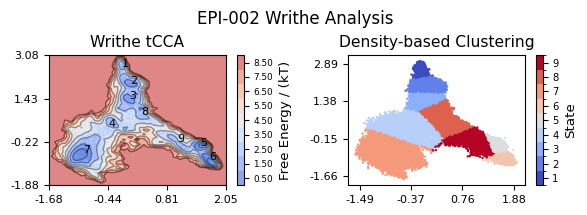

In [348]:
labels, centroids = density_peak_clustering(x = projs[1].T[0], y=projs[1].T[1])
labels = merge_cluster_labels(labels, [5, 6])
reindex = np.array([7, 4, 1, 3, 2, 8, 9, 5, 6]) - 1
labels = reindex[labels]
centroids = group_by(labels, projs[1], partial(np.mean, axis=0))
frames_cl = group_by(labels)

fig, ax = plt.subplots(1, 2, figsize=(6, 2))
fes2d(projs[1][:, :2], cluster_centers=centroids, ax=ax[0],
      title='Writhe tCCA', font_scale=.8, **fes2d_args)
proj2d(projs[1][:, :2], c=labels, state_map=True, ax=ax[1],
       cmap='coolwarm', title = 'Density-based Clustering', font_scale=.8)
fig.tight_layout()
fig.suptitle("EPI-002 Writhe Analysis", y=1.05)

# 1aa : Writhe tCCA Density Based clustering

Text(0.5, 1.05, '1aa Writhe Analysis')

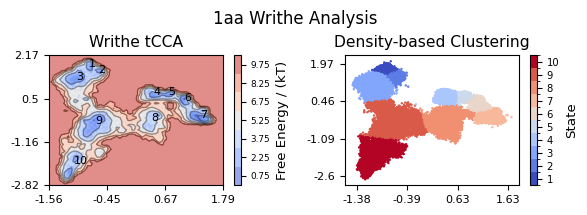

In [359]:
labels, centroids = density_peak_clustering(x = projs[2].T[0], y=projs[2].T[1],
                                            smoothing_sigma=1.3,
                                            threshold_rel=.05)
labels = merge_cluster_labels(labels, [1, 3])
labels = merge_cluster_labels(labels, [0, 2])
reindex = np.array([10, 3, 1, 9, 2, 4, 8, 5, 6, 7]) - 1
labels = reindex[labels]
centroids = group_by(labels, projs[2], partial(np.mean, axis=0))
frames_cl = group_by(labels)

fig, ax = plt.subplots(1, 2, figsize=(6, 2))
fes2d(projs[2][:, :2], cluster_centers=centroids, ax=ax[0],
      title='Writhe tCCA', font_scale=.8, **fes2d_args)
proj2d(projs[2][:, :2], c=labels, state_map=True, ax=ax[1],
       cmap='coolwarm', title = 'Density-based Clustering', font_scale=.8)
fig.tight_layout()
fig.suptitle("1aa Writhe Analysis", y=1.05)




# Writhe tCCA Latent Space Analysis

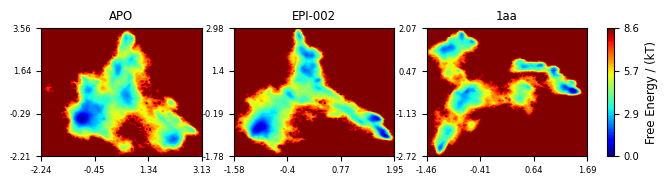

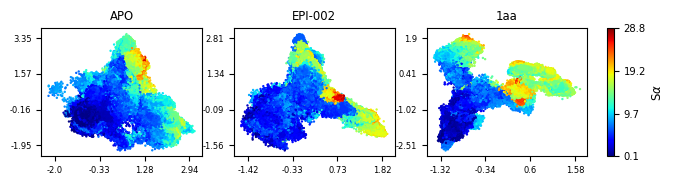

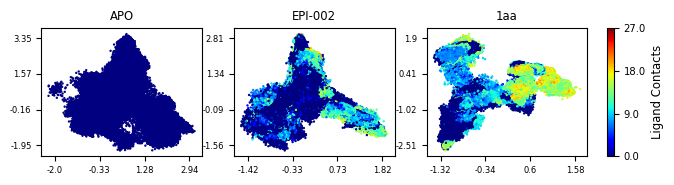

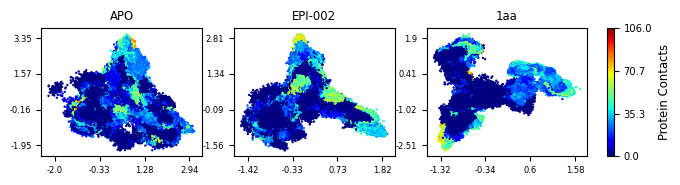

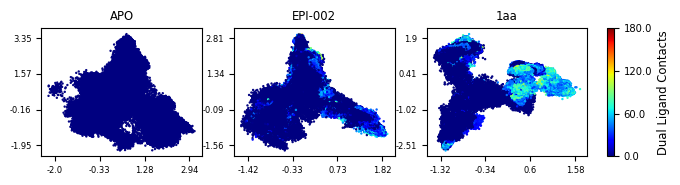

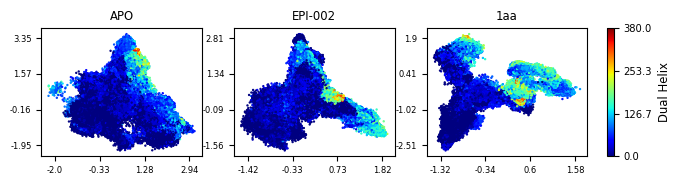

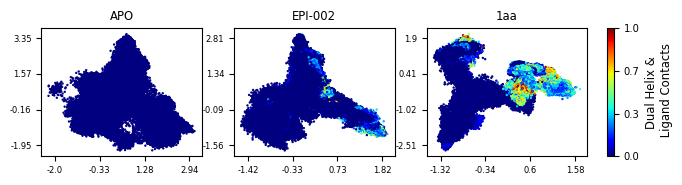

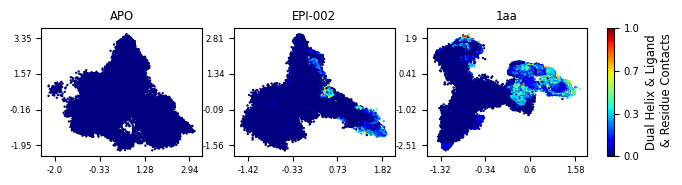

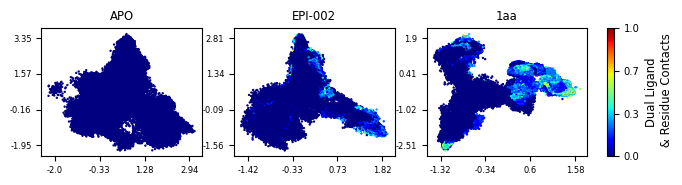

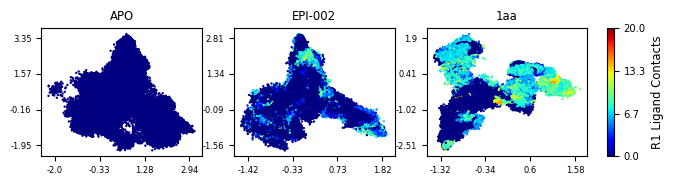

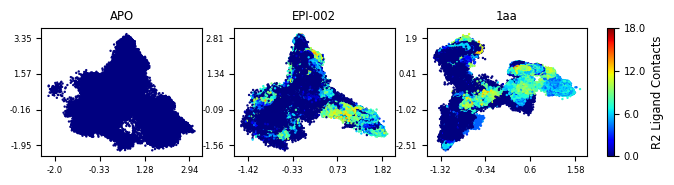

In [103]:

dot_size = 0.0001



subplots_fes2d([i[:, :2] for i in projs], 1, 3, labels, figsize=(7.2, 2), share_extent=False)

subplots_proj2d([i[1:, :2] for i in projs],
                [np.load(f'{path}/r1r2_sa.npy').sum(-1) for path in paths],
                1, 3, labels,
                figsize=(7.2, 2 ),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= r"S$\alpha$")


subplots_proj2d([i[1:, :2] for i in projs],
                [to_contacts(np.load(f'{path}/ligand_distances.npy')).sum(-1)
                 for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "Ligand Contacts",
)

subplots_proj2d([i[1:, :2] for i in projs],
                [ResidueDistances.load(path).contacts(.6).sum(-1)
                 for path in r1r2_distance_paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "Protein Contacts")

subplots_proj2d([i[1:, :2] for i in projs],
                [product(split(to_contacts(np.load(f'{path}/ligand_distances.npy'))), sum_=True)
                 for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "Dual Ligand Contacts",
)



subplots_proj2d([i[1:, :2] for i in projs],
                [product(split(np.load(f'{path}/dsspH.npy')), sum_=True) for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                #vmax=70,
                cbar_label= "Dual Helix",
)

from itertools import chain
subplots_proj2d([i[1:, :2] for i in projs],
                ligand_helix,
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                #vmax=70,
                cbar_label= "Dual Helix &\n Ligand Contacts",
)

subplots_proj2d([i[1:, :2] for i in projs],
                protein_ligand_helix,
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                #vmax=0.6,
                cbar_label= "Dual Helix & Ligand\n & Residue Contacts",
)

subplots_proj2d([i[1:, :2] for i in projs],
                protein_ligand,
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                #vmax=0.6,
                cbar_label= "Dual Ligand\n & Residue Contacts",
)



subplots_proj2d([i[1:, :2] for i in projs],
                [to_contacts(np.load(f'{path}/ligand_distances.npy')[:, :24]).sum(-1)
                 for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "R1 Ligand Contacts")

subplots_proj2d([i[1:, :2] for i in projs],
                [to_contacts(np.load(f'{path}/ligand_distances.npy')[:, 24:]).sum(-1)
                 for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "R2 Ligand Contacts")


In [ ]:
scores_ch = [ch_scores(i[:, :2], np.arange(3, 25)) for i in projs]
scores_db = [db_scores(i[:, :2], np.arange(3, 25)) for i in projs]


fig, axes = plt.subplots(1, 3, figsize=(16, 2), sharey=False)
for score, ax, label, color in zip(scores_db, axes.flat, labels, ['steelblue', 'gray', 'indianred']):
    score = score[:16]
    ax.scatter(*score.T, color=color)
    ax.set_title(label)
    ax.set_xticks(score.T[0], score.T[0].astype(int))
    ax.grid(True, alpha=.5)


fig, axes = plt.subplots(1, 3, figsize=(16, 2), sharey=False)
for score, ax, label, color in zip(scores_ch, axes.flat, labels, ['steelblue', 'gray', 'indianred']):
    score = score[:15]
    ax.scatter(*score.T, color=color)
    ax.set_title(label)
    ax.set_xticks(score.T[0], score.T[0].astype(int))
    ax.grid(True, alpha=.5)

In [105]:
projs = [np.load(lsdir(path, keyword='writhe_tcca_lag_')[0])[:, :3] for path in paths]
projs = [projs[0][1:]]
lags = [35, 35]
for path, lag in zip(paths[1:], lags):

    features = np.concatenate([ResidueDistances.load(f'{path}/r1r2_distance_dict.pkl').contacts(0.5),
                              np.load(f'{path}/dsspH.npy')], axis=-1)
    
    cca = CCA(features[:-lag],
              np.where(np.load(f'{path}/ligand_distances.npy') < 0.5, 1, 0)[lag:]
             ).fit()
    
    projs.append(cca.transform(features))

In [ ]:

projs = [np.load(lsdir(path, keyword='writhe_tcca_lag_')[0])[:, :3] for path in paths]
projs = [projs[0][1:]]
lags = [100, 100]
for path, lag in zip(paths[1:], lags):

    features = np.concatenate([gauss(ResidueDistances.load(f'{path}/r1r2_distance_dict.pkl').distances),
                              np.load(f'{path}/dsspH.npy')], axis=-1)
    
    cca = CCA(features[:-lag],
              gauss(np.load(f'{path}/ligand_distances.npy'))[lag:]
             ).fit()
    
    projs.append(cca.transform(features))

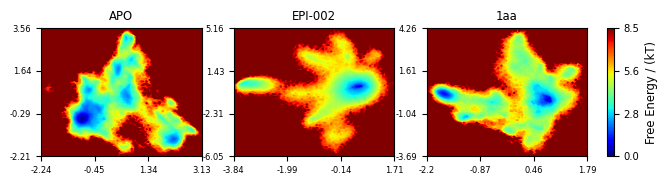

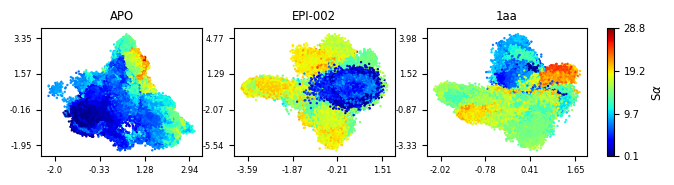

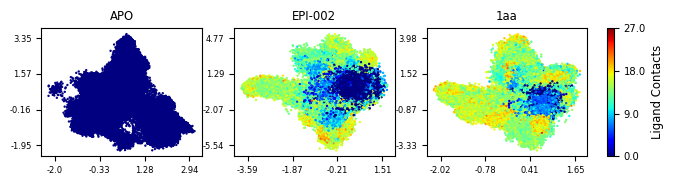

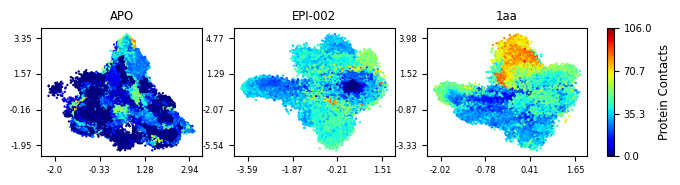

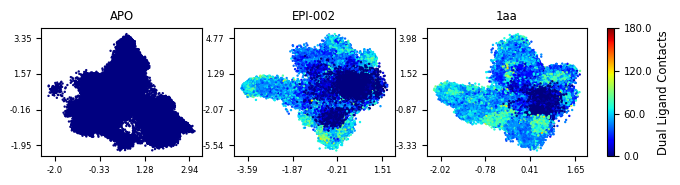

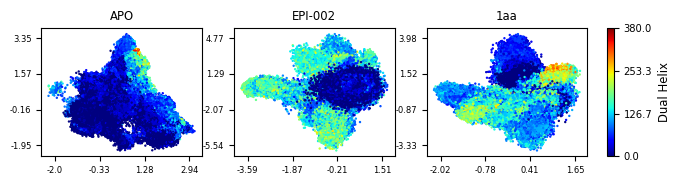

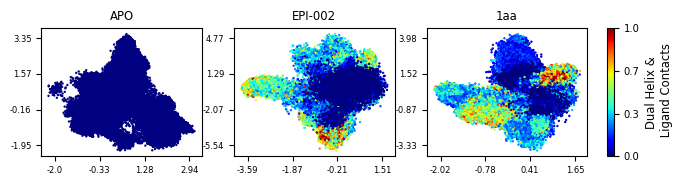

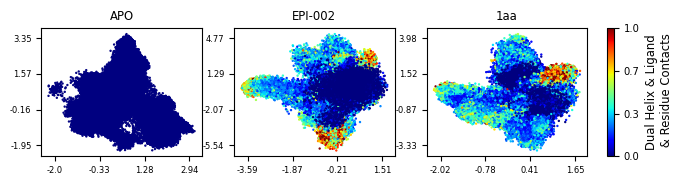

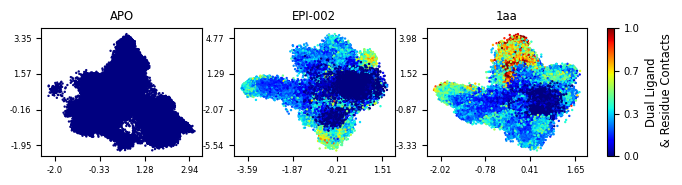

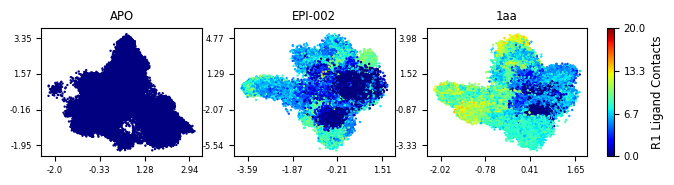

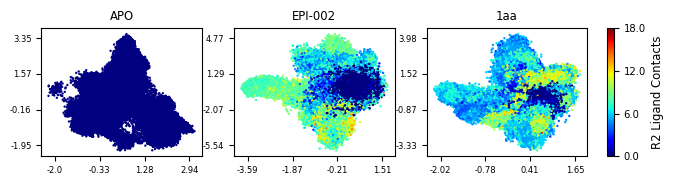

In [106]:
dot_size = 0.0001

subplots_fes2d([i[:, :2] for i in projs], 1, 3, labels, figsize=(7.2, 2), share_extent=False)

subplots_proj2d([i[:, :2] for i in projs],
                [np.load(f'{path}/r1r2_sa.npy').sum(-1) for path in paths],
                1, 3, labels,
                figsize=(7.2, 2 ),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= r"S$\alpha$")


subplots_proj2d([i[:, :2] for i in projs],
                [to_contacts(np.load(f'{path}/ligand_distances.npy')).sum(-1)
                 for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "Ligand Contacts",
)

subplots_proj2d([i[:, :2] for i in projs],
                [ResidueDistances.load(path).contacts(.6).sum(-1)
                 for path in r1r2_distance_paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "Protein Contacts")

subplots_proj2d([i[:, :2] for i in projs],
                [product(split(to_contacts(np.load(f'{path}/ligand_distances.npy'))), sum_=True)
                 for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "Dual Ligand Contacts",
)



subplots_proj2d([i[:, :2] for i in projs],
                [product(split(np.load(f'{path}/dsspH.npy')), sum_=True) for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,

                #vmax=70,
                cbar_label= "Dual Helix",
)

from itertools import chain
subplots_proj2d([i[:, :2] for i in projs],
                ligand_helix,
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                #vmax=70,
                cbar_label= "Dual Helix &\n Ligand Contacts",
)

subplots_proj2d([i[:, :2] for i in projs],
                protein_ligand_helix,
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                #vmax=0.6,
                cbar_label= "Dual Helix & Ligand\n & Residue Contacts",
)

subplots_proj2d([i[:, :2] for i in projs],
                protein_ligand,
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                #vmax=0.6,
                cbar_label= "Dual Ligand\n & Residue Contacts",
)



subplots_proj2d([i[:, :2] for i in projs],
                [to_contacts(np.load(f'{path}/ligand_distances.npy')[:, :24]).sum(-1)
                 for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "R1 Ligand Contacts")

subplots_proj2d([i[:, :2] for i in projs],
                [to_contacts(np.load(f'{path}/ligand_distances.npy')[:, 24:]).sum(-1)
                 for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "R2 Ligand Contacts")


In [ ]:
scores_ch = [ch_scores(i[:, :2], np.arange(2, 25)) for i in projs]
scores_db = [db_scores(i[:, :2], np.arange(3, 25)) for i in projs]


fig, axes = plt.subplots(1, 3, figsize=(16, 2), sharey=False)
for score, ax, label, color in zip(scores_db, axes.flat, labels, ['steelblue', 'gray', 'indianred']):
    score = score[:16]
    ax.scatter(*score.T, color=color)
    ax.set_title(label)
    ax.set_xticks(score.T[0], score.T[0].astype(int))
    ax.grid(True, alpha=.5)


fig, axes = plt.subplots(1, 3, figsize=(16, 2), sharey=False)
for score, ax, label, color in zip(scores_ch, axes.flat, labels, ['steelblue', 'gray', 'indianred']):
    score = score[:15]
    ax.scatter(*score.T, color=color)
    ax.set_title(label)
    ax.set_xticks(score.T[0], score.T[0].astype(int))
    ax.grid(True, alpha=.5)

In [284]:
import numpy as np
from sklearn.cluster import KMeans
from typing import Optional, List, Union
import ray
from writhe_tools.stats import silhouette_scores

def db_score(X, k):
    kmeans = KMeans(n_clusters=k).fit(X)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    distances = kmeans.transform(X)  # shape (n_samples, k)

    # Step 1: Compute σ_i for each cluster (mean intra-cluster distance to centroid)
    sigmas = np.zeros(k)
    for i in range(k):
        mask = (labels == i)
        sigmas[i] = np.mean(distances[mask, i]) if np.any(mask) else 0

    # Step 2: Compute DB index using only upper triangle
    D = np.zeros(k)
    for i in range(k):
        for j in range(i + 1, k):
            dist_ij = np.linalg.norm(centers[i] - centers[j])
            if dist_ij == 0:
                continue  # avoid division by zero
            R_ij = (sigmas[i] + sigmas[j]) / dist_ij
            D[i] = max(D[i], R_ij)
            D[j] = max(D[j], R_ij)

    return np.mean(D)


def db_scores(X: np.ndarray, ks:Union[List[int], np.ndarray]):
    fxn = ray.remote(db_score)
    ref = ray.put(X)
    result = np.array(ray.get([fxn.remote(ref, i) for i in ks]))
    return np.stack([np.asarray(ks), 1 - (result / result.max())], axis=-1)

import numpy as np
from sklearn.cluster import KMeans

def approximate_silhouette_score(X, k):
    kmeans = KMeans(n_clusters=k).fit(X)
    labels = kmeans.labels_
    distances = kmeans.transform(X)  # shape (n_samples, k)

    a = distances[np.arange(len(X)), labels]  # distance to own centroid
    b = np.min(np.where(
        np.eye(k)[labels][:, :, None] == 0,  # mask out own cluster
        distances[:, :, None], 
        np.inf
    ), axis=1).squeeze()  # distance to closest other centroid

    denom = np.maximum(a, b)
    scores = np.where(denom > 0, (b - a) / denom, 0.0)

    return np.mean(scores)


def approximate_silhouette_scores(X: np.ndarray, ks:Union[List[int], np.ndarray]):
    fxn = ray.remote(approximate_silhouette_score)
    ref = ray.put(X)
    return np.stack([np.asarray(ks),
                     np.array(ray.get([fxn.remote(ref, i) for i in ks]))], axis=-1)

import numpy as np
from sklearn.cluster import KMeans

def ch_score(X: np.ndarray, k: int, **kmeans_kwargs) -> float:
    """
    Compute the Calinski-Harabasz score manually and fast using KMeans outputs.
    
    Parameters:
    - X: (n_samples, n_features) data matrix
    - n_clusters: number of clusters to fit
    - kmeans_kwargs: any other keyword args for sklearn.cluster.KMeans
    
    Returns:
    - CH index (float)
    """
    n_samples, _ = X.shape

    # Run KMeans
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs).fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    overall_mean = X.mean(axis=0)

    # Count samples per cluster
    unique_labels, counts = np.unique(labels, return_counts=True)

    # Between-cluster sum of squares
    diff = centroids - overall_mean  # shape (k, d)
    B = np.sum(counts[:, np.newaxis] * diff**2)
    # Within-cluster sum of squares (same as kmeans.inertia_)
    W = kmeans.inertia_

    # CH score
    k = len(centroids)
    return (B / (k - 1)) / (W / (n_samples - k))


def ch_scores(X: np.ndarray, ks: Union[List[int], np.ndarray]):
    fxn = ray.remote(ch_score)
    ref = ray.put(X)
    result = np.array(ray.get([fxn.remote(ref, i) for i in ks]))
    
    return np.stack([np.asarray(ks), result / result.max()], axis=-1)


#scores = [db_scores(i, np.arange(3, 25)) for i in projs]
#scores = [approximate_silhouette_scores(i, np.arange(3, 25)) for i in projs]

# from writhe_tools.stats import silhouette_scores


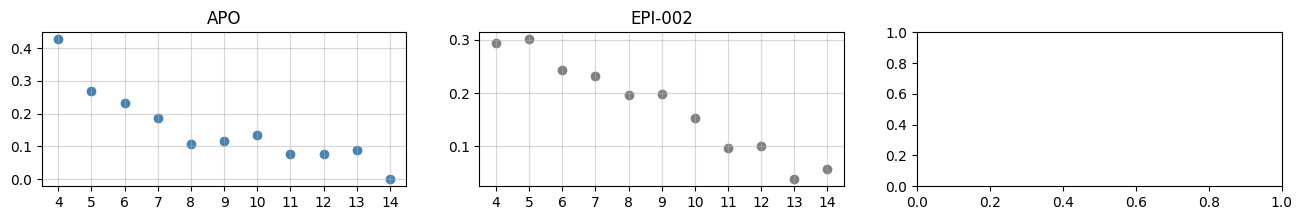

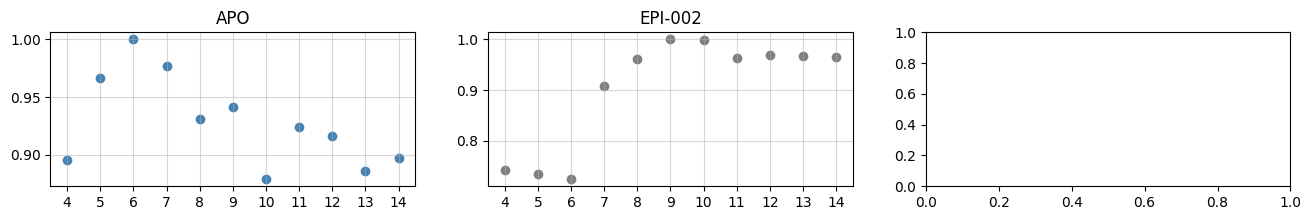

In [285]:
scores_ch = [ch_scores(i[:, :2], np.arange(4, 25)) for i in projs]
scores_db = [db_scores(i[:, :2], np.arange(4, 25)) for i in projs]


fig, axes = plt.subplots(1, 3, figsize=(16, 2), sharey=False)
for score, ax, label, color in zip(scores_db, axes.flat, labels, ['steelblue', 'gray', 'indianred']):
    score = score[:11]
    ax.scatter(*score.T, color=color)
    ax.set_title(label)
    ax.set_xticks(score.T[0], score.T[0].astype(int))
    ax.grid(True, alpha=.5)


fig, axes = plt.subplots(1, 3, figsize=(16, 2), sharey=False)
for score, ax, label, color in zip(scores_ch, axes.flat, labels, ['steelblue', 'gray', 'indianred']):
    score = score[:11]
    ax.scatter(*score.T, color=color)
    ax.set_title(label)
    ax.set_xticks(score.T[0], score.T[0].astype(int))
    ax.grid(True, alpha=.5)

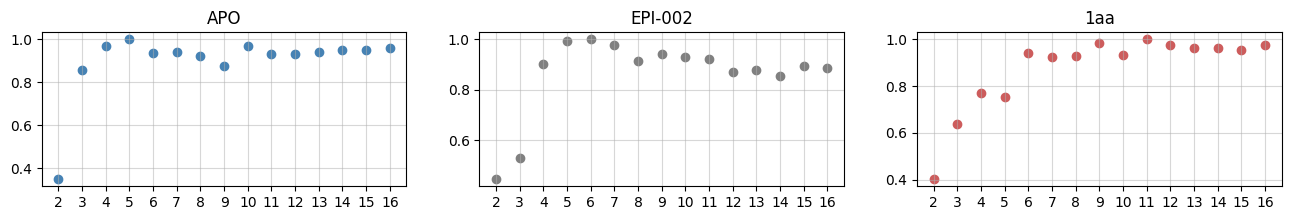

 # Protein - Protein Distances along the chain(s) Check

In [11]:
for i in protein_files:
    
    traj = md.load(i,
                   top=protein_pdb,
                   stride=100)

    print(traj.unitcell_lengths.mean(0))
    
    #traj.image_molecules(inplace=True)

    traj = traj_slice(traj, 'name CA and chainid 0')

    print(traj.n_atoms)
    
    distances = residue_distances(traj,
                                  indices=np.stack([np.arange(23),np.arange(1, 24)], axis=1),
                                  periodic=True,
                                  parallel=True)[0]

    print(distances.max())
    

[7.93214 7.93214 7.93214]
48
0.41158
[7.9289265 7.9289265 7.9289265]
48
0.4094195
[10.906101 10.906101 10.906101]
48
0.40931672


In [12]:
for i in protein_files:
    
    traj = md.load(i,
                   top=protein_pdb,
                   stride=100)

    print(traj.unitcell_lengths.mean(0))
    
    #traj.image_molecules(inplace=True)

    traj = traj_slice(traj, 'name CA and chainid 0')

    print(traj.n_atoms)
    
    distances = residue_distances(traj,
                                  indices=np.stack([np.arange(23),np.arange(1, 24)], axis=1),
                                  periodic=False,
                                  parallel=True)[0]

    print(distances.max())

[7.93214 7.93214 7.93214]
48
0.41158
[7.9289265 7.9289265 7.9289265]
48
0.4094195
[10.906101 10.906101 10.906101]
48
0.40931672


In [13]:
for i in protein_files:
    
    traj = md.load(i,
                   top=protein_pdb,
                   stride=100)

    print(traj.unitcell_lengths.mean(0))
    
    #traj.image_molecules(inplace=True)

    traj = traj_slice(traj, 'name CA')

    print(traj.n_atoms)
    
    distances = residue_distances(traj,
                                  indices=np.stack([np.arange(24, 47),
                                                    np.arange(25, 48)], axis=1),
                                  periodic=True,
                                  parallel=True)[0]

    print(distances.max())
    

[7.93214 7.93214 7.93214]
48
0.40932056
[7.9289265 7.9289265 7.9289265]
48
0.4129768
[10.906101 10.906101 10.906101]
48
0.4094823


In [14]:
for i in protein_files:
    
    traj = md.load(i,
                   top=protein_pdb,
                   stride=100)

    print(traj.unitcell_lengths.mean(0))
    
    #traj.image_molecules(inplace=True)

    traj = traj_slice(traj, 'name CA')

    print(traj.n_atoms)
    
    distances = residue_distances(traj,
                                  indices=np.stack([np.arange(24, 47),
                                                    np.arange(25, 48)], axis=1),
                                  periodic=False,
                                  parallel=True)[0]

    print(distances.max())

[7.93214 7.93214 7.93214]
48
0.40932056
[7.9289265 7.9289265 7.9289265]
48
0.4129768
[10.906101 10.906101 10.906101]
48
0.4094823


# protein - Ligand Distances

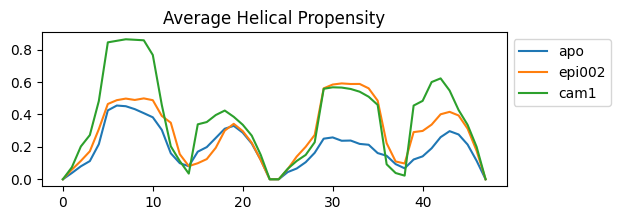

In [3]:
plt.figure(figsize=(6, 2))
plt.title("Average Helical Propensity")
for path, traj_file in zip(paths, protein_files):
    
    traj = md.load(traj_file,
                   top=protein_pdb,
                   stride=1)


    ca_index = get_residues(traj)[-1]

    alpha = np.where(md.compute_dssp(traj) == 'H', 1, 0)[:, ca_index]

    plt.plot(alpha.mean(0), label=path.split('/')[-1])

plt.legend(bbox_to_anchor=[1, 1])
np.save(f'{path}/dsspH', alpha)


In [25]:
from importlib import reload
import writhe_tools
reload(writhe_tools)
reload(writhe_tools.md_tools)
from writhe_tools.md_tools import ResidueDistances

In [4]:
traj = md.load(protein_files[1], top=protein_pdb)
sequence, ca_index = get_residues(traj)

ResidueDistances(traj=traj,
                 index_0=ca_index[:24],
                 index_1 = ca_index[24:],
                 parallel=False).save(paths[1], 'r1r2')


# chunks = np.array_split(np.arange(traj.n_frames))

# np.concatenate([residue_distances(traj[i],
#                                   index_0=ca_index[:24],
#                                   index_1 = ca_index[24:])
#                 for i in chunks])



In [ ]:
plt.figure(figsize=(6, 2))
plt.title("Average Residue - Ligand Distances")
residues = []
for path, traj_file, top_file in zip(paths[1:],
                                     ligand_files,
                                     ligand_pdbs):
    
    traj = md.load(traj_file,
                   top=top_file,
                   stride=1
                  )

    sequence, ca_index = get_residues(traj)


    lig_index = [i for i, j in enumerate(sequence) if j in ['EPI0', 'LIG1']][0]
    

    print(traj.unitcell_lengths.mean(0))
    
    distances = residue_distances(traj,
                                  ca_index,
                                  np.array([lig_index]),
                                  periodic=True,
                                  parallel=False)[0]
    
    print(f'(Max / Min) Ligand - Protein Distances: ({distances.max()} / {distances.min()})')
    plt.plot(distances.mean(0),
             label=path.split('/')[-1] + f' % Bound (any) : {(distances < 0.6).any(1).mean() * 100:.1f}')
    
    np.save(f'{path}/ligand_distances', distances)

    del distances

    indices = np.array_split(ca_index, 2)

    distances = ResidueDistances(traj=traj,
                                 index_0=indices[0],
                                 index_1=indices[1])

    distances.save(path, 'r1r2')

    del distances
    del traj
            

plt.legend()

[7.941126 7.941126 7.941126]
(Max / Min) Ligand - Protein Distances: (6.249910831451416 / 0.1523464471101761)


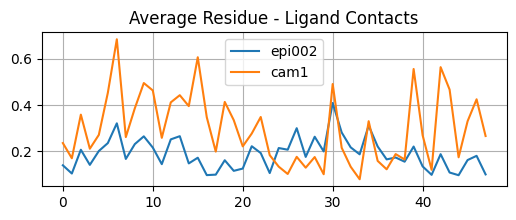

In [4]:
plt.figure(figsize=(6, 2))
plt.title("Average Residue - Ligand Contacts")
for path, traj_file, top_file in zip(paths[1:],
                                     ligand_files,
                                     ligand_pdbs):

    
    distances = np.where(np.load(f'{path}/ligand_distances.npy') < 0.6, 1, 0).mean(0)

    plt.plot(distances, label=f'{path.split("/")[-1]}')

plt.grid(True)
plt.savefig('residue_ligand_contacts')
plt.legend()


In [5]:
distances = np.load(f'{paths[1]}/ligand_distances.npy')

# Ternary Complex 

In [29]:
bound = []
for i, path in zip(protein_files[1:], paths[1:]):
    
    r1r2 = (ResidueDistances.load(f'{path}/r1r2_distance_dict.pkl').contacts(0.6).sum(-1)).astype(bool)
    
    lig = (np.where(np.load(f'{path}/ligand_distances.npy') < 0.6, 1, 0)[:, :24].sum(-1) *
           np.where(np.load(f'{path}/ligand_distances.npy') < 0.6, 1, 0)[:, 24:].sum(-1)
          ).astype(bool)
    
    bound.append(lig * r1r2)
    del r1r2
    del lig
    
    
{j : i.mean() for i, j in zip(bound, labels[1:])}  

{'EPI-002': 0.4772164354629674, '1aa': 0.7137754010695188}

 # Writhe Computation

In [32]:
for i, path in zip(protein_files, paths):
    
    xyz = md.load(i,
                  top=protein_pdb,
                  atom_indices=md.load(protein_pdb).top.select('name CA')).center_coordinates().xyz
    
    
    
    for x, dscr in zip(np.array_split(xyz, 2, axis=1), 'r1,r2'.split(',')):
    
        writhe = Writhe(x)
    
        writhe.compute_writhe(1, cuda=True)

        writhe.save(path, dscr)

    writhe = Writhe(xyz)

    writhe.compute_writhe(segments=np.concatenate([get_segments(index0=np.arange(24), 
                                                                index1=np.arange(24, 48)),
                                                   get_segments(index0=np.arange(24)),
                                                   get_segments(index0=np.arange(24, 48))]),
                          cuda=True)

    writhe.save(path, 'r1r2')

    writhe.compute_writhe(1, cuda=True)

    writhe.save(path, 'r1r2')


In [317]:
fes2d_args = dict(
      cmap="coolwarm",
      bins=55,
      n_contours=8,
      contour_lines=True,
      alpha_lines=0.35,
      alpha_contours=0.6,
      mask=False,
      scatter=True,
      scatter_alpha = .15,
      scatter_size=.05,
      scatter_stride=50,
      scatter_max=.35,
      scatter_min=.15,
      scatter_cmap="coolwarm",
      hide_ax=False,
      extend_border=0.1,
    )

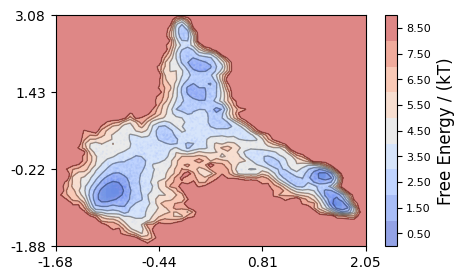

In [20]:
fes2d_args = dict(
      cmap="coolwarm",
      bins=55,
      n_contours=8,
      contour_lines=True,
      alpha_lines=0.35,
      alpha_contours=0.6,
      mask=False,
      scatter=True,
      scatter_alpha = .15,
      scatter_size=.05,
      scatter_stride=50,
      scatter_max=.35,
      scatter_min=.15,
      scatter_cmap="coolwarm",
      hide_ax=False,
      extend_border=0.1,
    )
    
fes2d(projs[1][:, :2], **fes2d_args)

In [156]:
writhe_paths = [lsdir(path, keyword=['writhe', 'pkl', 'r1r2'])[0] for path in paths]
distance_paths = [f'{path}/ligand_distances.npy' for path in paths[1:]]

 # dimensionality reduction

In [29]:
projs = []
lag = 35
for path in paths[1:]:
    
    cca = CCA(np.concatenate([ResidueDistances.load(f'{path}/r1r2_distance_dict.pkl').distances,
                              Writhe.load(f'{path}/r1_writhe_data_dict_length_1.pkl').writhe_features,
                              Writhe.load(f'{path}/r2_writhe_data_dict_length_1.pkl').writhe_features
                             ], axis=-1)[:-lag],
              np.load(f'{path}/ligand_distances.npy')[lag:]
             ).fit()
    
    projs.append(cca.transform('x0'))

for i in projs:
    fes2d(i[:, :2])


In [40]:
projs = []
lag = 35
for path in paths[1:]:
    
    cca = CCA(np.concatenate([Writhe.load(f'{path}/r1r2_writhe_data_dict_length_1.pkl').writhe_features,
                              Writhe.load(f'{path}/r1_writhe_data_dict_length_1.pkl').writhe_features,
                              Writhe.load(f'{path}/r2_writhe_data_dict_length_1.pkl').writhe_features
                             ], axis=-1)[:-lag],
              np.load(f'{path}/ligand_distances.npy')[lag:]
             ).fit()
    
    projs.append(cca.transform('x0'))

for i in projs:
    fes2d(i[:, :2])


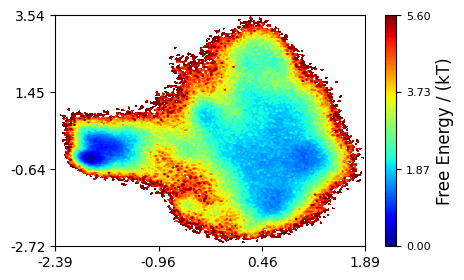

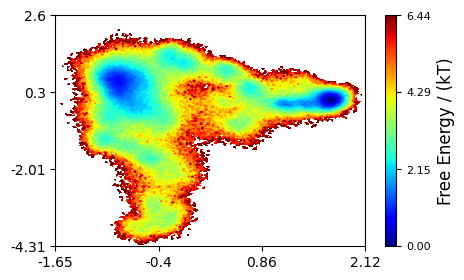

In [42]:
projs = []
lag = 35
for path in paths[1:]:
    
    cca = CCA(np.concatenate([ResidueDistances.load(f'{path}/r1r2_distance_dict.pkl').contacts(0.6),
                              Writhe.load(f'{path}/r1_writhe_data_dict_length_1.pkl').writhe_features,
                              Writhe.load(f'{path}/r2_writhe_data_dict_length_1.pkl').writhe_features
                             ], axis=-1)[:-lag],
              np.load(f'{path}/ligand_distances.npy')[lag:]
             ).fit()
    
    projs.append(cca.transform('x0'))

for i in projs:
    fes2d(i[:, :2])

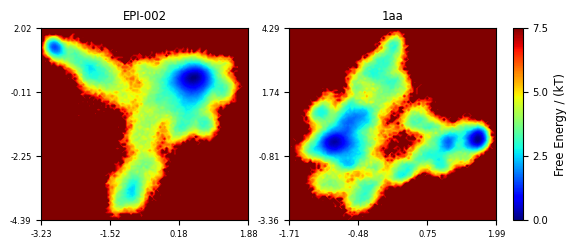

In [330]:
projs = []
lag = 35
for path in paths[1:]:
    
    cca = CCA(np.concatenate([ResidueDistances.load(f'{path}/r1r2_distance_dict.pkl').contacts(0.6),
                              Writhe.load(f'{path}/r1_writhe_data_dict_length_1.pkl').writhe_features,
                              Writhe.load(f'{path}/r2_writhe_data_dict_length_1.pkl').writhe_features
                             ], axis=-1)[:-lag],
              np.where(np.load(f'{path}/ligand_distances.npy') < 0.6, 1, 0)[lag:]
             ).fit()
    
    projs.append(cca.transform('x0'))


subplots_fes2d([i[:, :2] for i in projs],
               1, 2,
               dscrs=labels[1:], figsize=(6, 3), share_extent=False)

# for i in projs:
#     fes2d(i[:, :2])

 # calculate SA

In [131]:
from writhe_tools.md_tools import calc_sa

In [134]:
traj = md.load(protein_files[0],
               top=protein_pdb,
               atom_indices=md.load(protein_pdb).top.select('name CA')
              )
print(traj_slice(traj, 'resid 0 to 23'),
      traj_slice(traj, 'resid 24 to 47')
     )

<mdtraj.Trajectory with 416660 frames, 24 atoms, 24 residues, and unitcells> <mdtraj.Trajectory with 416660 frames, 24 atoms, 24 residues, and unitcells>


In [75]:
for i, path in zip(protein_files, paths):
    
    traj = md.load(i,
              top=protein_pdb,
              atom_indices=md.load(protein_pdb).top.select('name CA'))
    
        
    np.save(f'{path}/r1r2_sa',
            np.concatenate([calc_sa(trj=traj_slice(traj, selection), 
                                    helix='/data/r1r2/monomer_r1r2_helix.pdb')
            for selection in ['resid 0 to 23', 'resid 24 to 47']], 1))
    
    
    
    

 # This projection works for 1AA

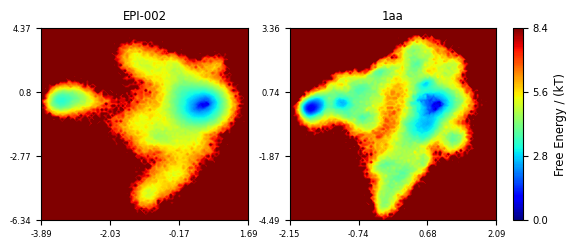

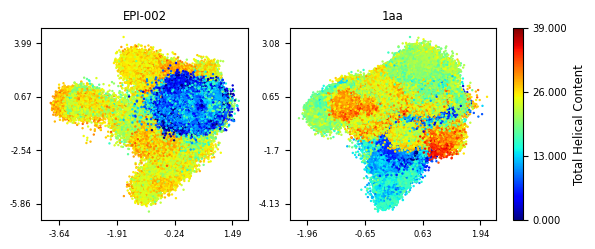

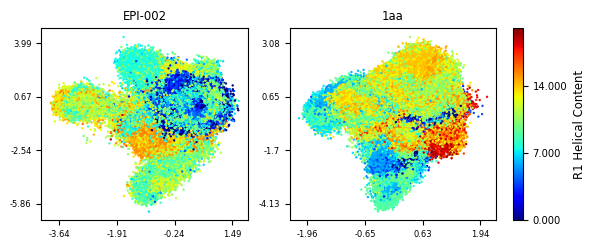

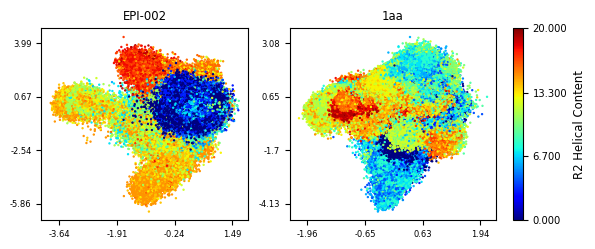

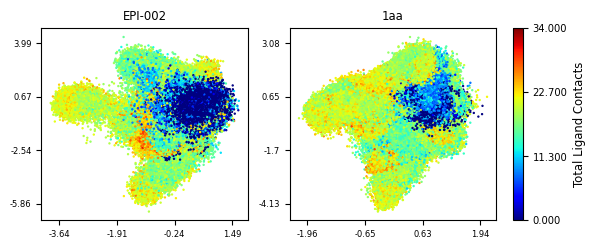

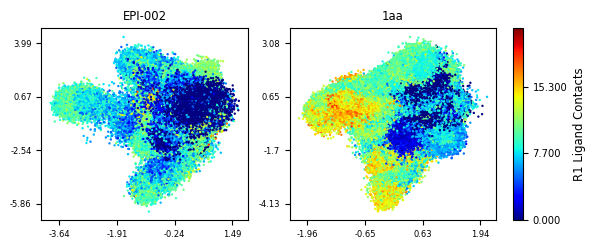

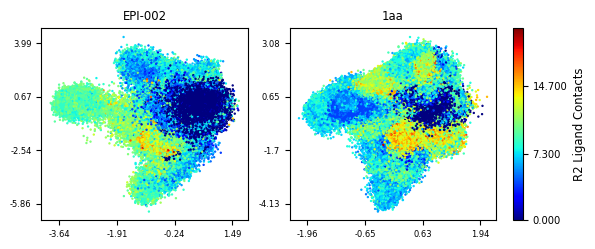

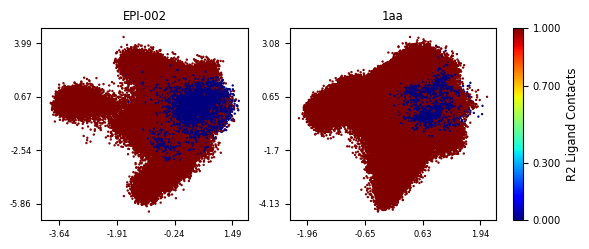

In [65]:
projs = []
lags = [50, 50]
for path, lag in zip(paths[1:], lags):

    features = np.concatenate([ResidueDistances.load(f'{path}/r1r2_distance_dict.pkl').contacts(0.6),
                              np.load(f'{path}/dsspH.npy')], axis=-1)
    
    cca = CCA(features[:-lag],
              np.where(np.load(f'{path}/ligand_distances.npy') < 0.6, 1, 0)[lag:]
             ).fit()
    
    projs.append(cca.transform(features))

del features

projs[-1][:, 1] = -1 * projs[-1][:, 1]


subplots_fes2d([i[:, :2] for i in projs],
               1,
               2,
               dscrs=labels[1:],
               figsize=(6, 3),
               share_extent=False,
               #cbar_label='Total Helical Content',
              )

subplots_proj2d([i[:, :2] for i in projs],
                c=[np.load(i).sum(-1) for i in dssp_paths[1:]],
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='Total Helical Content')

subplots_proj2d([i[:, :2] for i in projs],
                c=[np.load(i)[:, :24].sum(-1) for i in dssp_paths[1:]],
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='R1 Helical Content')

subplots_proj2d([i[:, :2] for i in projs],
                c=[np.load(i)[:, 24:].sum(-1) for i in dssp_paths[1:]],
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='R2 Helical Content')

subplots_proj2d([i[:, :2] for i in projs],
                c=[np.where(np.load(f'{path}/ligand_distances.npy') < 0.6, 1, 0).sum(-1)
                   for path in paths[1:]],
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='Total Ligand Contacts')

subplots_proj2d([i[:, :2] for i in projs],
                c=[np.where(np.load(f'{path}/ligand_distances.npy')[:, :24] < 0.6, 1, 0).sum(-1)
                   for path in paths[1:]],
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='R1 Ligand Contacts')

subplots_proj2d([i[:, :2] for i in projs],
                c=[np.where(np.load(f'{path}/ligand_distances.npy')[:, 24:] < 0.6, 1, 0).sum(-1)
                   for path in paths[1:]],
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='R2 Ligand Contacts')

subplots_proj2d([i[:, :2] for i in projs],
                c=bound,
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='R2 Ligand Contacts')




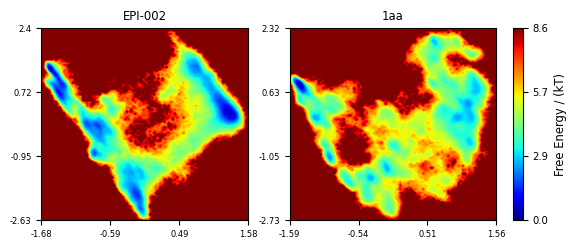

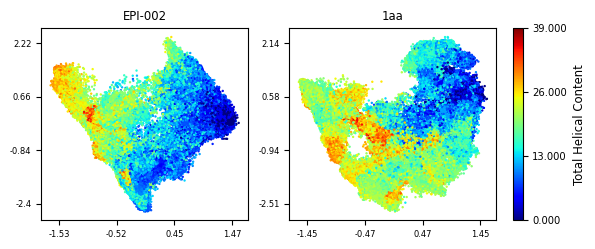

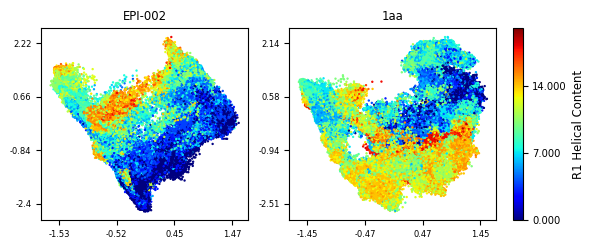

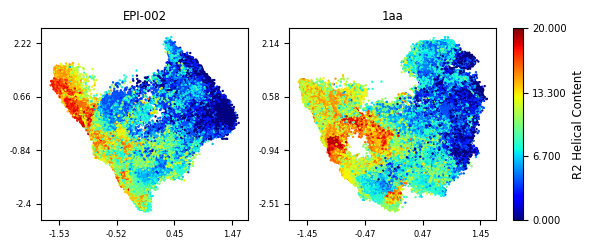

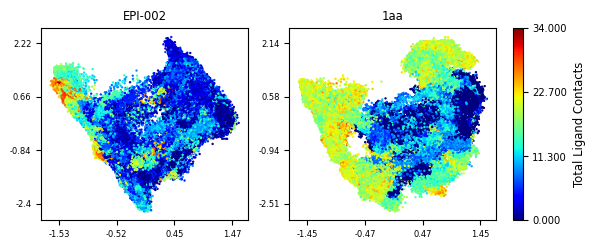

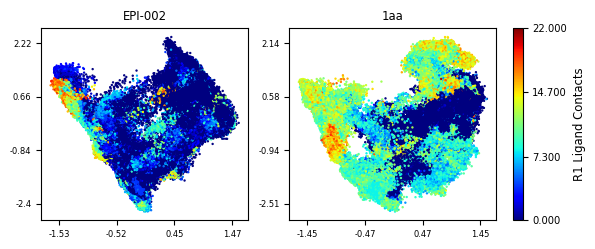

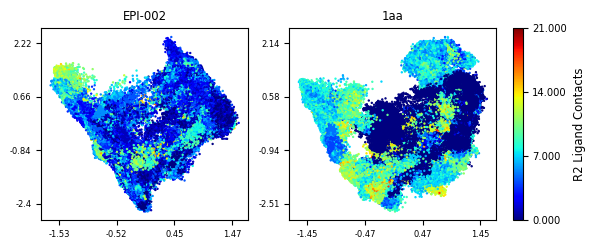

In [155]:
projs = []
lag = 35
for path in paths[1:]:

    features = np.concatenate([Writhe.load(f'{path}/r1r2_writhe_data_dict_length_1.pkl').writhe_features,
                               ResidueDistances.load(f'{path}/r1r2_distance_dict.pkl').contacts(0.6),
                               np.load(f'{path}/r1r2_sa.npy')
                              ], axis=-1)
    
    
    cca = CCA(features[:-lag],
              np.concatenate([np.where(np.load(f'{path}/ligand_distances.npy') < 0.6, 1, 0),
                              np.load(f'{path}/dsspH.npy')
                             ], axis=-1
                            )[lag:]
              ).fit()
    
    projs.append(cca.transform(features))

del features


subplots_fes2d([i[:, :2] for i in projs],
               1, 
               2,
               dscrs=labels[1:],
               figsize=(6, 3),
               share_extent=False,
               #cbar_label='Total Helical Content',
              )

subplots_proj2d([i[:, :2] for i in projs],
                c=[np.load(i).sum(-1) for i in dssp_paths[1:]],
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='Total Helical Content')

subplots_proj2d([i[:, :2] for i in projs],
                c=[np.load(i)[:, :24].sum(-1) for i in dssp_paths[1:]],
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='R1 Helical Content')

subplots_proj2d([i[:, :2] for i in projs],
                c=[np.load(i)[:, 24:].sum(-1) for i in dssp_paths[1:]],
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='R2 Helical Content')

subplots_proj2d([i[:, :2] for i in projs],
                c=[np.where(np.load(f'{path}/ligand_distances.npy') < 0.6, 1, 0).sum(-1)
                   for path in paths[1:]],
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='Total Ligand Contacts')

subplots_proj2d([i[:, :2] for i in projs],
                c=[np.where(np.load(f'{path}/ligand_distances.npy')[:, :24] < 0.6, 1, 0).sum(-1)
                   for path in paths[1:]],
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='R1 Ligand Contacts')

subplots_proj2d([i[:, :2] for i in projs],
                c=[np.where(np.load(f'{path}/ligand_distances.npy')[:, 24:] < 0.6, 1, 0).sum(-1)
                   for path in paths[1:]],
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='R2 Ligand Contacts')


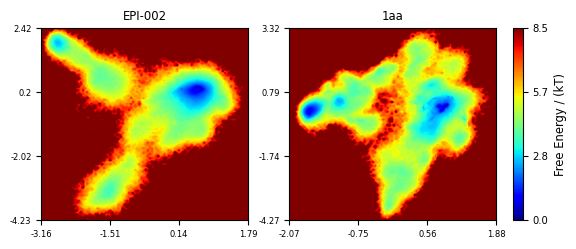

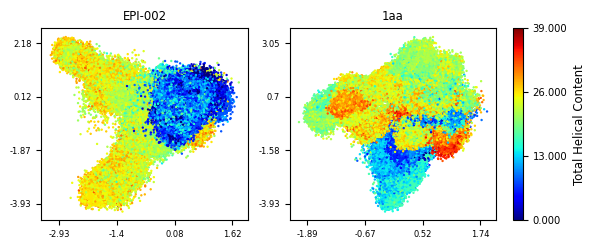

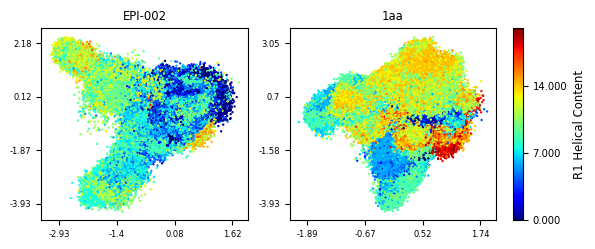

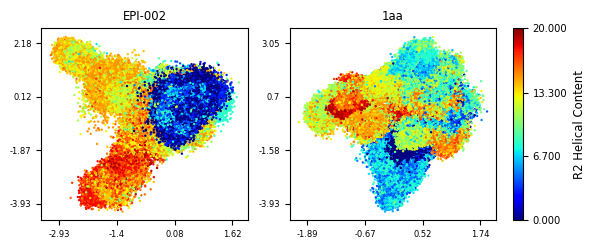

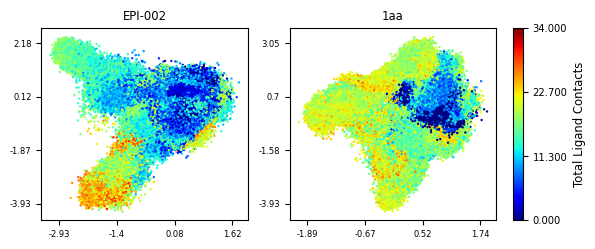

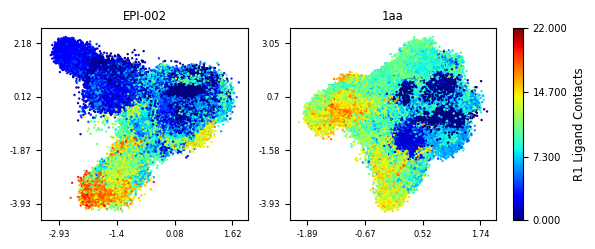

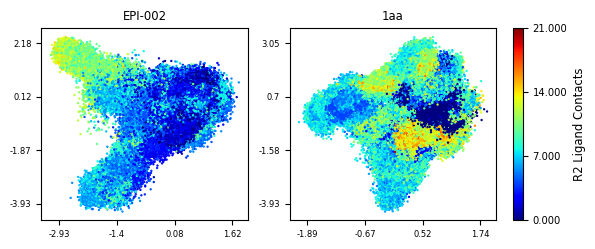

In [257]:
projs = []
lag = 35
for path in paths[1:]:

    features = np.concatenate([ResidueDistances.load(f'{path}/r1r2_distance_dict.pkl').contacts(0.6),
                              np.load(f'{path}/r1r2_sa.npy')], axis=-1)
    
    cca = CCA(features[:-lag],
              np.where(np.load(f'{path}/ligand_distances.npy') < 0.6, 1, 0)[lag:]
             ).fit()
    
    projs.append(cca.transform(features))

del features


subplots_fes2d([i[:, :2] for i in projs],
               1, 
               2,
               dscrs=labels[1:],
               figsize=(6, 3),
               share_extent=False,
               #cbar_label='Total Helical Content',
              )

subplots_proj2d([i[:, :2] for i in projs],
                c=[np.load(i).sum(-1) for i in dssp_paths[1:]],
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='Total Helical Content')

subplots_proj2d([i[:, :2] for i in projs],
                c=[np.load(i)[:, :24].sum(-1) for i in dssp_paths[1:]],
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='R1 Helical Content')

subplots_proj2d([i[:, :2] for i in projs],
                c=[np.load(i)[:, 24:].sum(-1) for i in dssp_paths[1:]],
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='R2 Helical Content')

subplots_proj2d([i[:, :2] for i in projs],
                c=[np.where(np.load(f'{path}/ligand_distances.npy') < 0.6, 1, 0).sum(-1)
                   for path in paths[1:]],
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='Total Ligand Contacts')

subplots_proj2d([i[:, :2] for i in projs],
                c=[np.where(np.load(f'{path}/ligand_distances.npy')[:, :24] < 0.6, 1, 0).sum(-1)
                   for path in paths[1:]],
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='R1 Ligand Contacts')

subplots_proj2d([i[:, :2] for i in projs],
                c=[np.where(np.load(f'{path}/ligand_distances.npy')[:, 24:] < 0.6, 1, 0).sum(-1)
                   for path in paths[1:]],
                rows=1, 
                cols=2,
                dscrs=labels[1:],
                figsize=(6, 3),
                share_extent=False,
                cbar_label='R2 Ligand Contacts')








In [298]:
projs = []
lags = [100, 250]
for path, lag in zip(paths[1:], lags):

    features = np.concatenate([ResidueDistances.load(f'{path}/r1r2_distance_dict.pkl').contacts(0.5),
                              np.load(f'{path}/dsspH.npy')], axis=-1)
    
    cca = CCA(features[:-lag],
              np.where(np.load(f'{path}/ligand_distances.npy') < 0.5, 1, 0)[lag:]
             ).fit()
    
    projs.append(cca.transform(features))

In [299]:
#n_clusters = np.array([100, 150, 300])
n_clusters = np.array([10, 13, 15, 40, 80, 100, 125, 150, 200, 300])
#clusters = {'epi':{}, '1aa': {}}
for n in n_clusters:
    clusters['epi'][n], clusters['1aa'][n] = (Kmeans(projs[i], n, 3, max_iter=1200, n_init=25)[0]
                                              for i in range(2))

#save_dict("contacts_intra_writhe", clusters)

In [71]:
clusters = load_dict('./contacts_dssp')

In [293]:
msms[0] = [MarkovModel(i[n_cluster]).estimate_msm(tau, 8).estimate_hmm(4)
        for i, n, tau, n_cluster in zip(clusters.values(), (4, 4), (115, 150)[:1], (15, 13))][0]

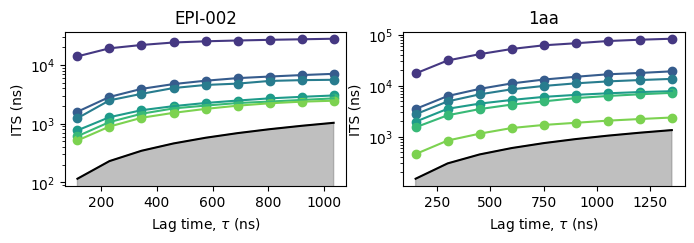

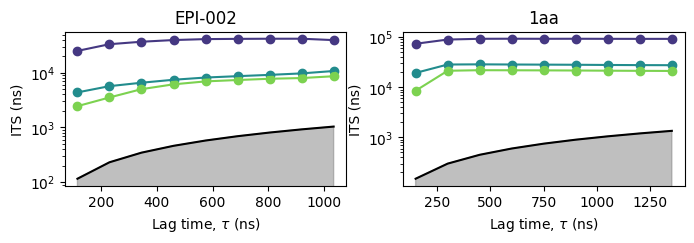

In [294]:
fig, axes = plt.subplots(1, 2, figsize=(8, 2))
for model, ax, label in zip(msms, axes.flat, labels[1:]):
    model.its('msm', ax=ax, n_its=6)
    ax.set_title(label)
fig, axes = plt.subplots(1, 2, figsize=(8, 2))
for model, ax, label in zip(msms, axes.flat, labels[1:]):
    model.its('hmm', ax=ax, )
    ax.set_title(label)

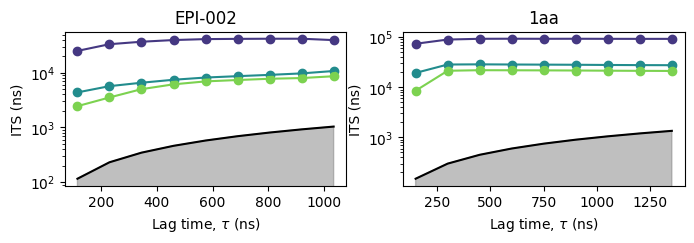

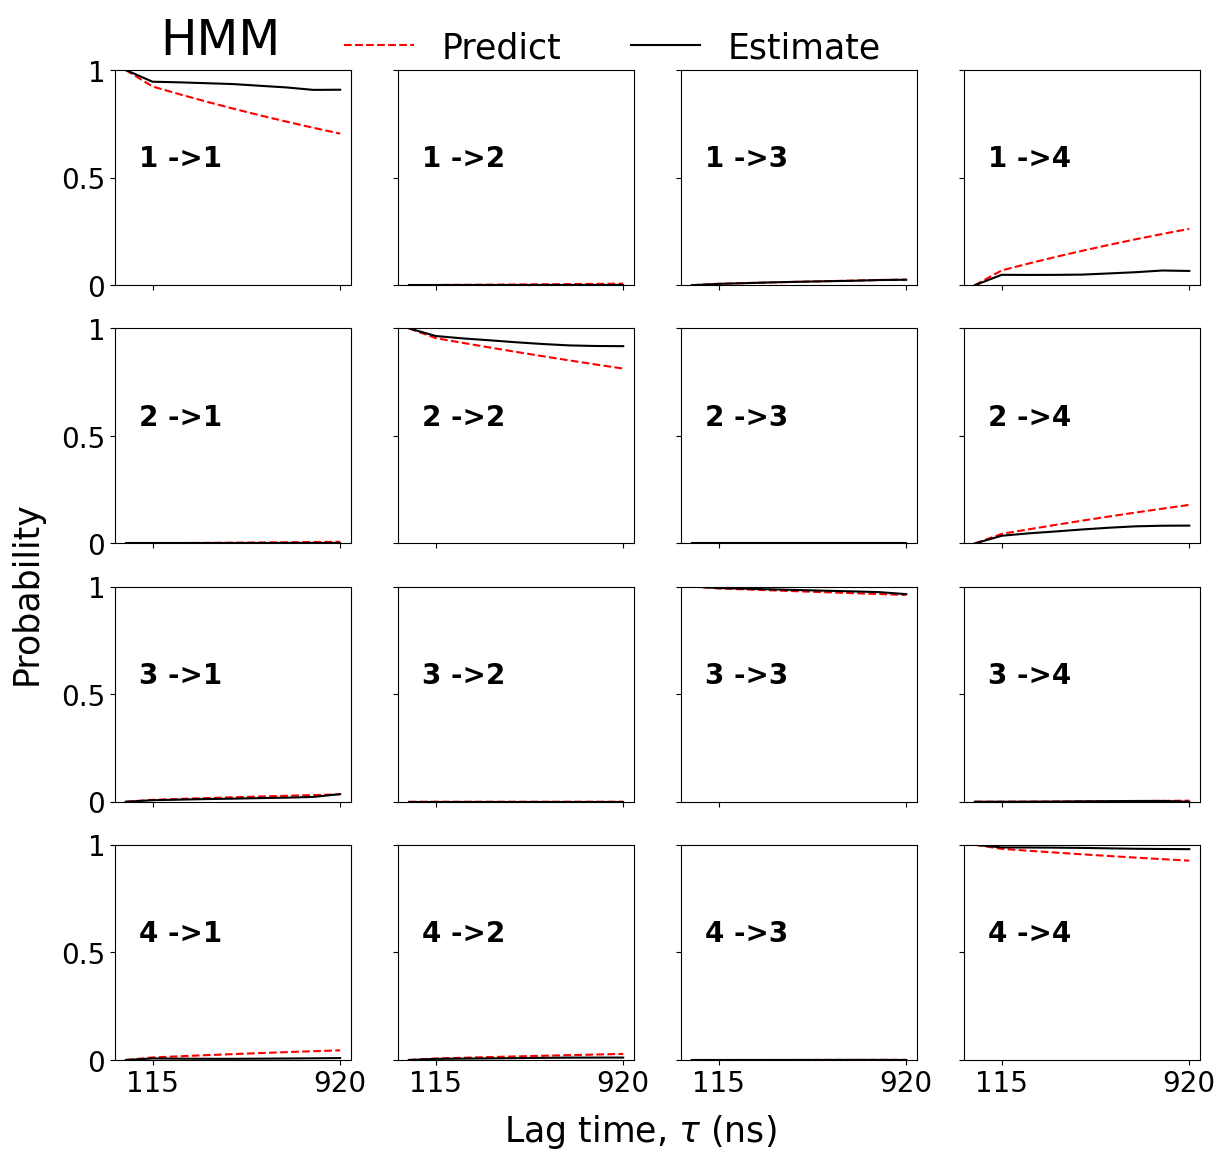

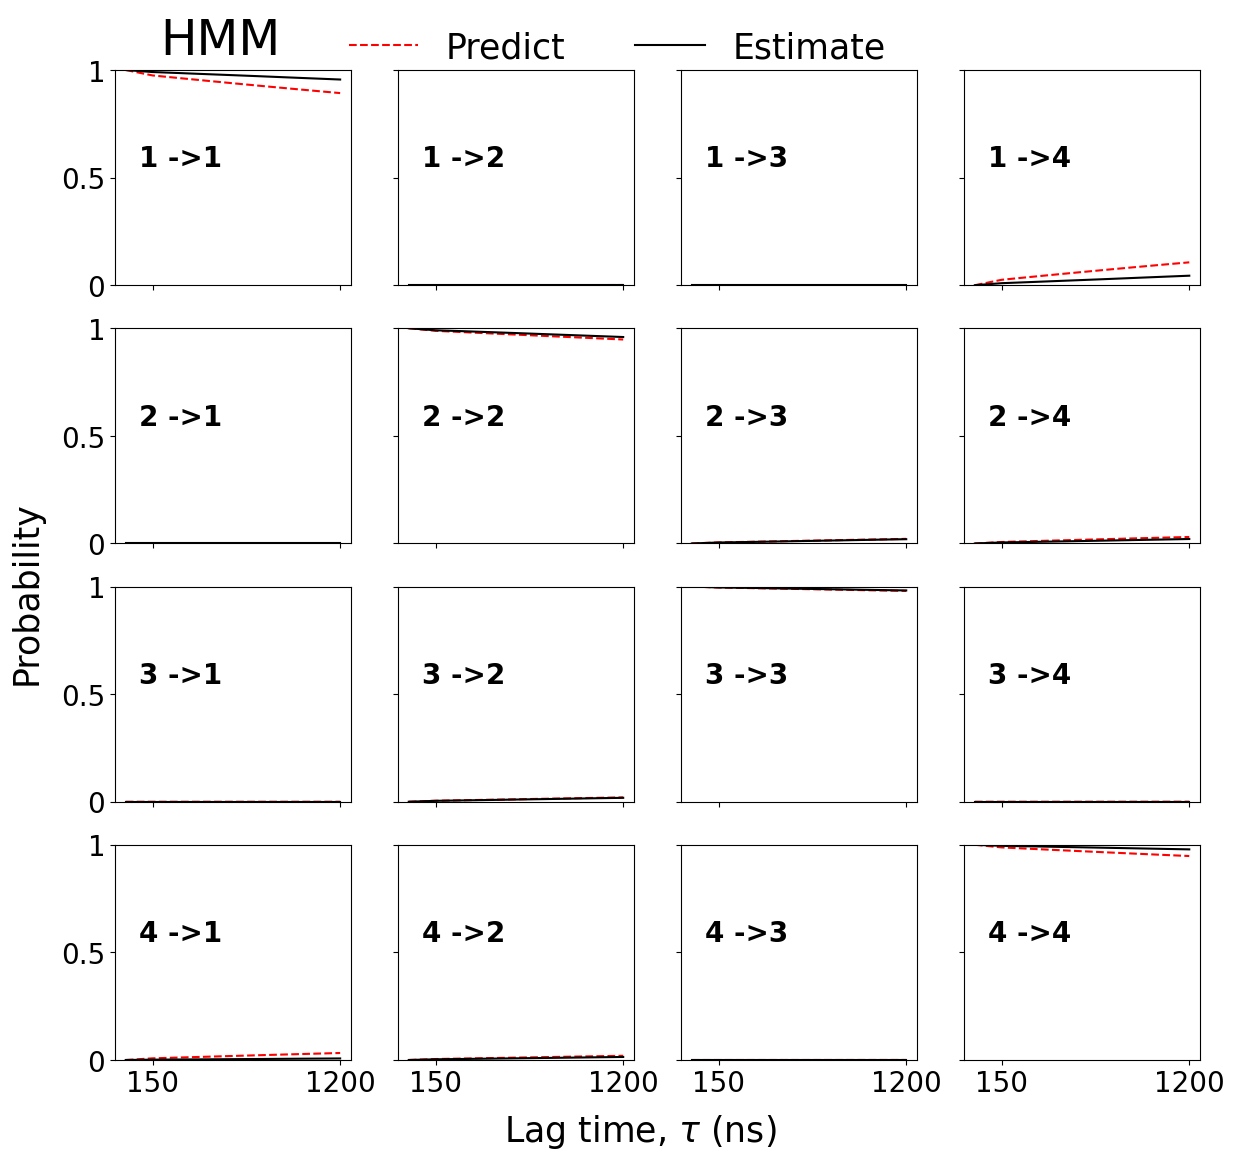

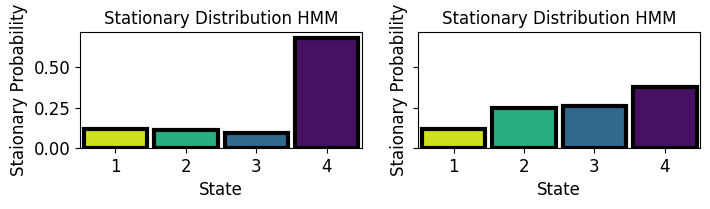

In [295]:
fig, axes = plt.subplots(1, 2, figsize=(8, 2))
for model, ax, label in zip(msms, axes.flat, labels[1:]):
    model.its('hmm', ax=ax, )
    ax.set_title(label)


for model in msms:
    model.cktest('hmm', figsize=(14, 12))


fig, axes = plt.subplots(1, 2, figsize=(8, 1.5), sharey=True)
for model, ax in zip(msms, axes.flat):
    model.stationary_distribution('hmm', ax=ax)


In [219]:
def get_proj(lag: int):
    features = np.concatenate([ResidueDistances.load(f'{paths[1]}/r1r2_distance_dict.pkl').contacts(0.6),
                              np.load(f'{paths[1]}/dsspH.npy')], axis=-1)
    
    cca = CCA(features[:-lag],
              np.where(np.load(f'{paths[1]}/ligand_distances.npy') < 0.6, 1, 0)[lag:]
             ).fit()

    plt.scatter(np.arange(10), cca.svals[:10])
    
    return cca.transform(features)

In [ ]:
msms[0] = MarkovModel(clusters['epi'][12]).estimate_msm(100, 9).estimate_hmm(4)

In [241]:
n_micro = 15
dtraj = Kmeans(proj, n_micro, 2, max_iter=1200, n_init=25)[0]

In [242]:
msms[0] = MarkovModel(dtraj).estimate_msm(115, 10).estimate_hmm(4)

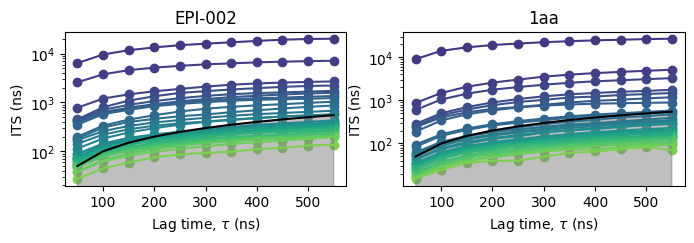

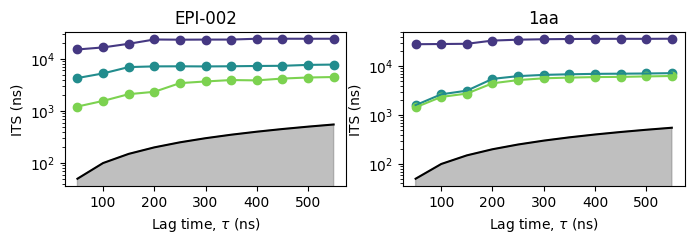

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(8, 2))
for model, ax, label in zip(msms, axes.flat, labels[1:]):
    model.its('msm', ax=ax, )
    ax.set_title(label)
fig, axes = plt.subplots(1, 2, figsize=(8, 2))
for model, ax, label in zip(msms, axes.flat, labels[1:]):
    model.its('hmm', ax=ax, )
    ax.set_title(label)

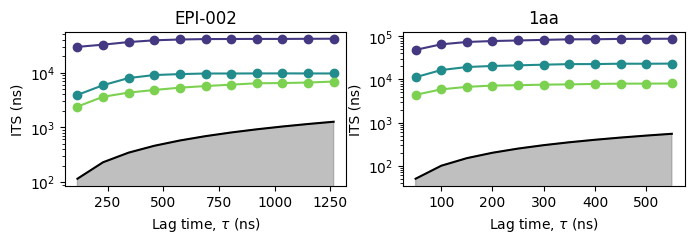

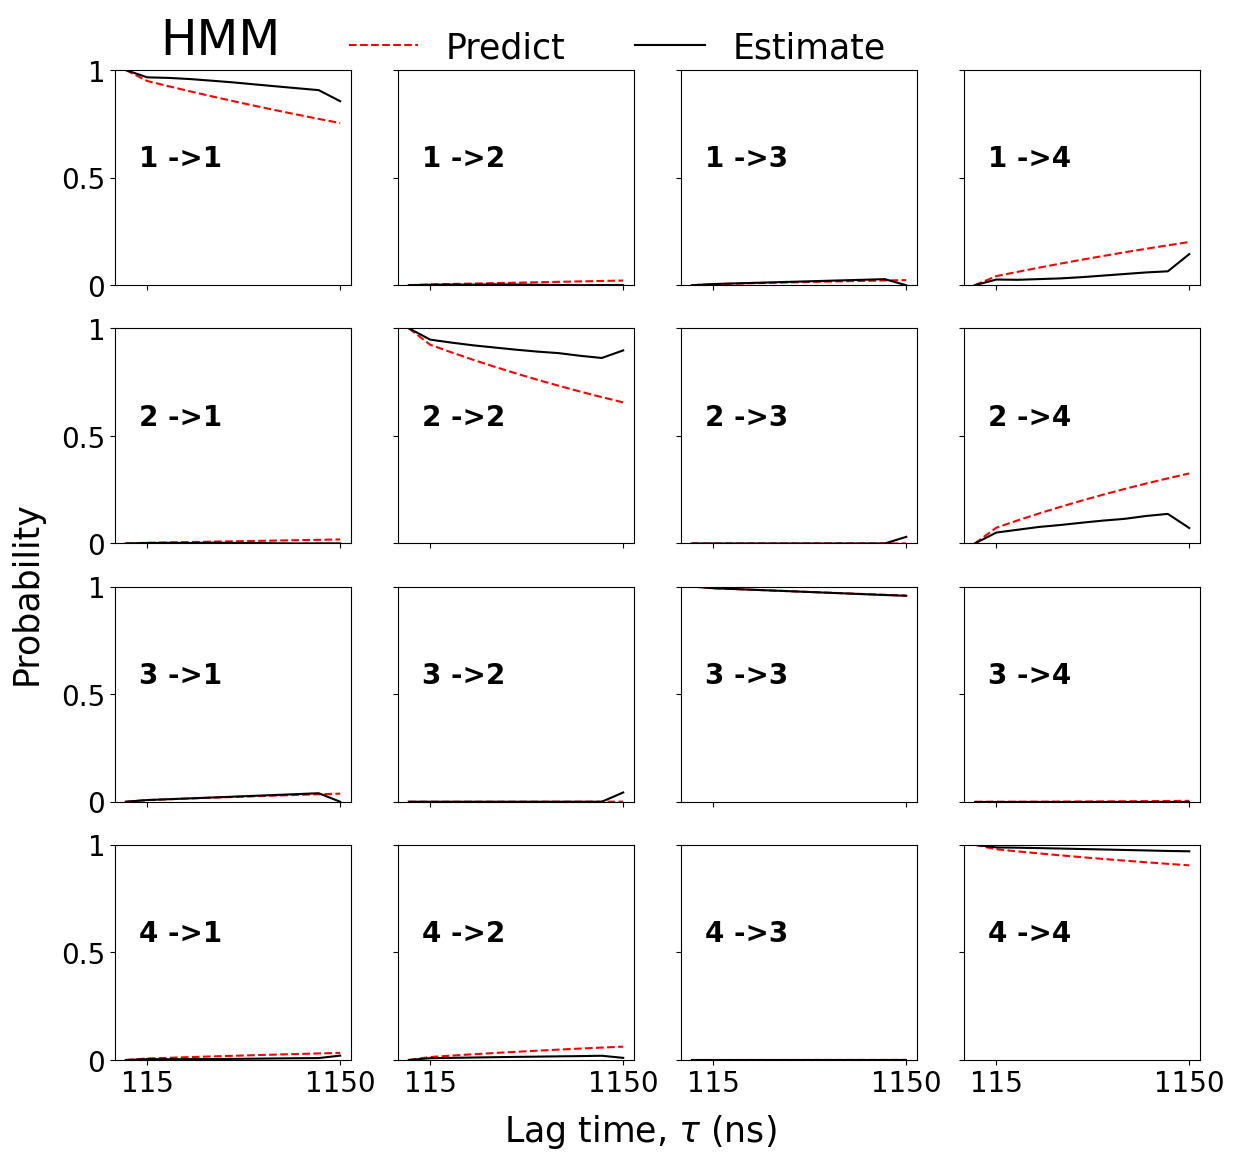

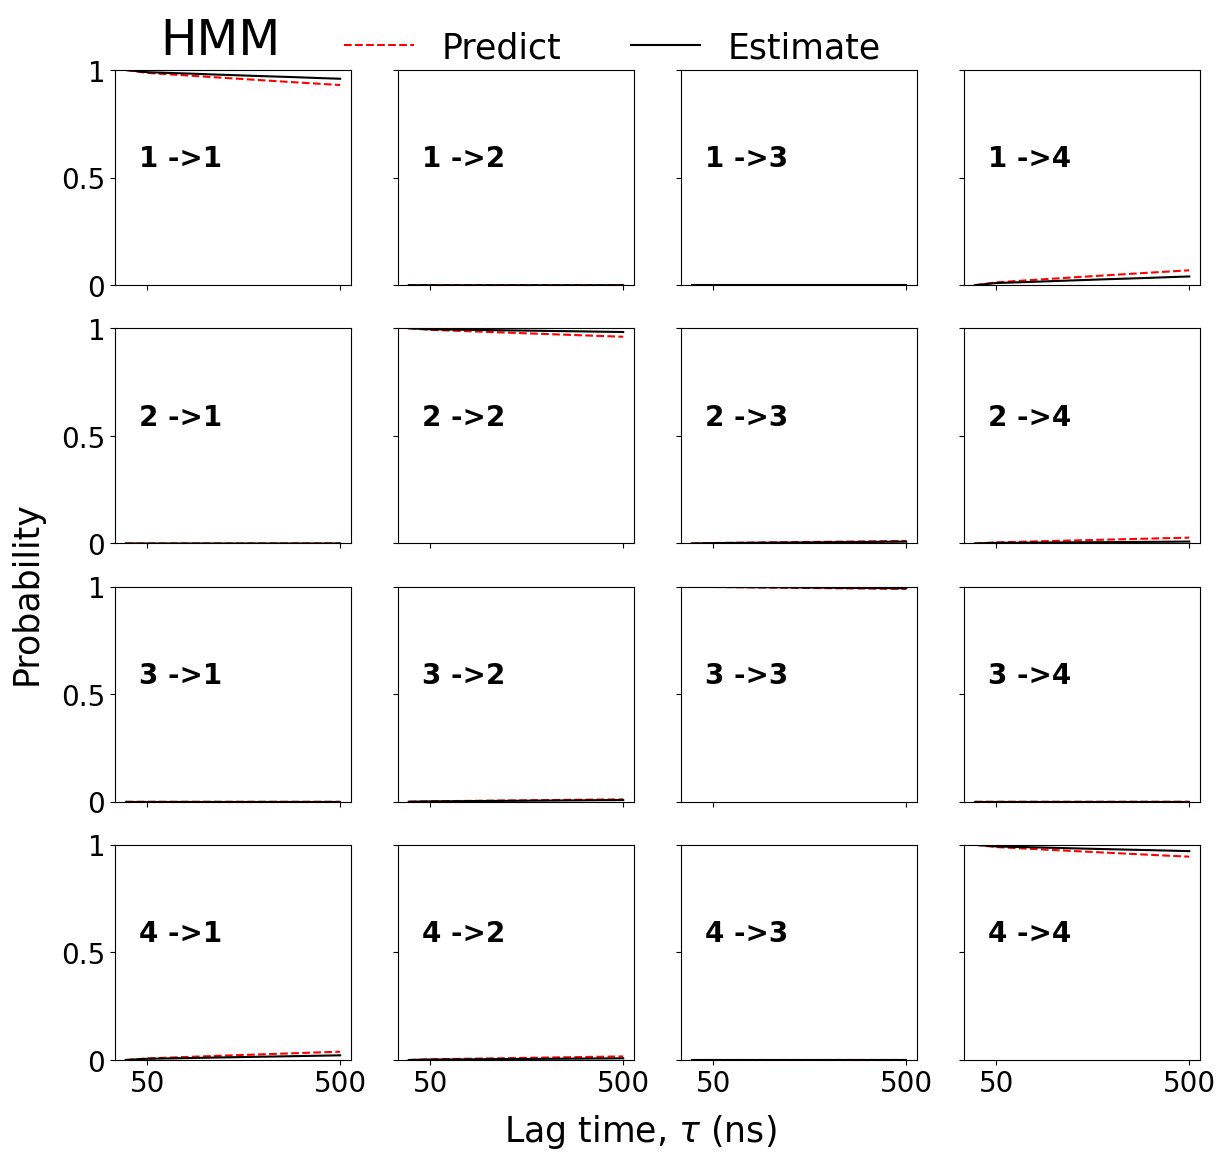

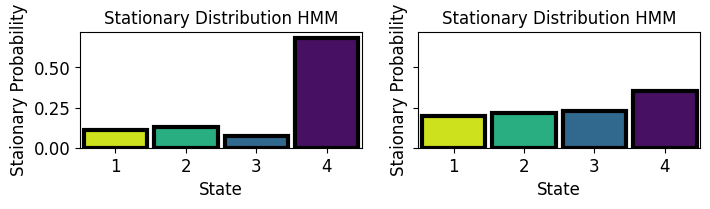

In [239]:
fig, axes = plt.subplots(1, 2, figsize=(8, 2))
for model, ax, label in zip(msms, axes.flat, labels[1:]):
    model.its('hmm', ax=ax, )
    ax.set_title(label)


for model in msms:
    model.cktest('hmm', figsize=(14, 12))


fig, axes = plt.subplots(1, 2, figsize=(8, 1.5), sharey=True)
for model, ax in zip(msms, axes.flat):
    model.stationary_distribution('hmm', ax=ax)



In [465]:
msms[0].hmm['data']['stat_dists'][0] * 100

array([ 5.8177514 ,  6.6921536 , 14.79966464, 72.69043035])

In [500]:
trunc = 80
pre_trunc=80

In [69]:
for model, path in zip(msms, paths[1:]):
    ligand_distances = np.load(f'{path}/ligand_distances.npy')
    #distances = ResidueDistances.load(
    frames = group_by(model.hmm['data']['dtrajs'][0])
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    fig.suptitle("Dual Ligand Contacts")
    for frame, ax in zip(frames, axes.flat):
        l1, l2 = np.array_split(np.where(ligand_distances[frame] < 0.6, 1, 0), 2, axis=1)
        plot_distance_matrix(l1.T @ l2 / len(frame), ax=ax, label_stride=3, vmin=0, vmax=1)

    
    fig, axes = plt.subplots(2, 2, figsize=(8, 3), sharex=True)
    
    fig.suptitle("Ligand Contacts")

    for i, (frame, ax) in enumerate(zip(frames, axes.flat)):
        
        l1, l2 = np.array_split(np.where(ligand_distances[frame] < 0.6, 1, 0), 2, axis=1)
        
        box_plot(l1.mean(0), label=f'State : {i+1}', ax=ax, cmap='Reds',
                 title = f"State {i+1}", ymin=0, ymax=1,
                 font_scale=1.1, alpha=.4, trunc=trunc, pre_trunc=pre_trunc)
        
        box_plot(l2.mean(0), label=f'State : {i+1}', ax=ax,
                 title = f"State {i+1}", ymin=0, ymax=1,
                 cmap='Blues', alpha=.4,
                 font_scale=1.1, trunc=trunc, pre_trunc=pre_trunc)

    fig, axes = plt.subplots(2, 2, figsize=(8, 3), sharex=True)
    
    fig.suptitle("Helical Proensity")

    dssp = np.load(f'{path}/dsspH.npy')
    for i, (frame, ax) in enumerate(zip(frames, axes.flat)):
        
        l1, l2 = np.array_split(dssp[frame], 2, axis=1)
        
        box_plot(l1.mean(0), label=f'State : {i+1}', ax=ax, cmap='Reds',
                 title = f"State {i+1}", ymin=0, ymax=1,
                 font_scale=1.1, alpha=.4, trunc=trunc, pre_trunc=pre_trunc)
        
        box_plot(l2.mean(0), label=f'State : {i+1}', ax=ax,
                 title = f"State {i+1}", ymin=0, ymax=1,
                 cmap='Blues', alpha=.4,
                 font_scale=1.1, trunc=trunc, pre_trunc=pre_trunc)
        

    
        

NameError: name 'msms' is not defined

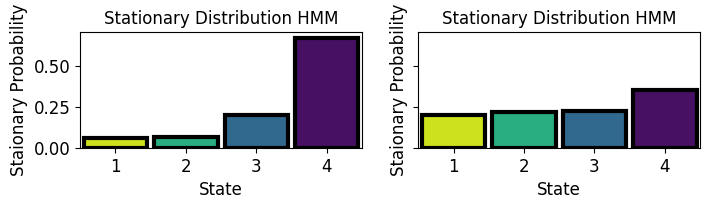

In [199]:
# model_test = MarkovModel(clusters['epi'][n_micro]).estimate_msm(5, 10).estimate_hmm(4)
# msms[0].hmm['data']['ck_pred'] = model_test.hmm['data']['ck_pred']

In [7]:
lsdir(path, keyword=['distance', 'pkl', 'r1', 'r2'], exclude=['r12'])

['/data/r1r2/cam1/r1r2_distance_dict.pkl']

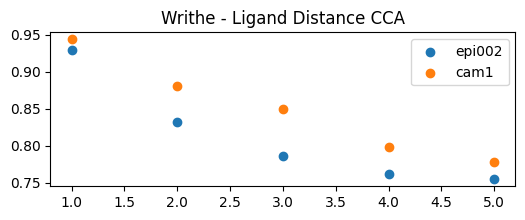

In [423]:
lag = 50
projs = []
plt.figure(figsize=(6, 2))
plt.title("Writhe - Ligand Distance CCA")
for i, j, lag in zip(writhe_paths[1:], distance_paths, (25, 75)):
    cca = CCA(Writhe.load(i).writhe_features[:-lag], np.load(j)[lag:]).fit(epsilon=1e-10)
    projs.append(cca.transform(Writhe.load(i).writhe_features))
    plt.scatter(np.arange(1, 6), cca.svals[:5], label=j.split('/')[-2])
plt.legend()
    

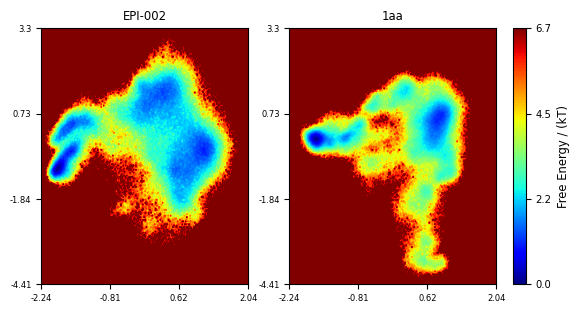

In [424]:
subplots_fes2d([i[:, :2] for i in projs], 1, 2,
               labels[1:], figsize=(6, 4), bins=180)

In [140]:
alphas = [np.load(path) for path in dssp_paths[1:]]

NameError: name 'distance_paths' is not defined

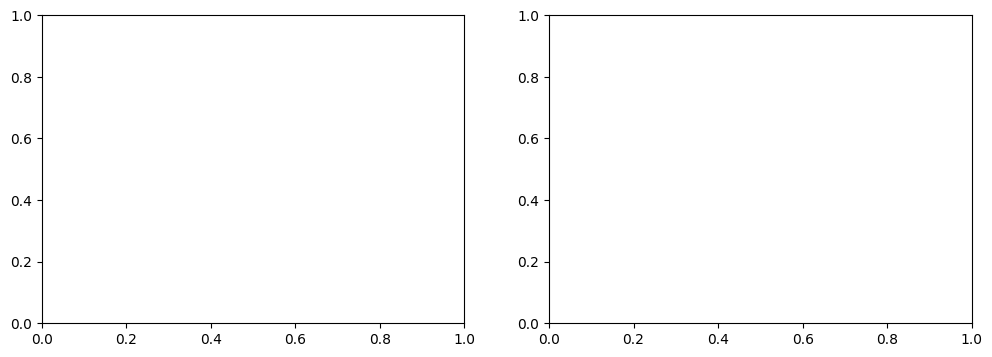

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, proj, path, label in zip(axes.flat,
                                 projs,
                                 distance_paths,
                                 labels[1:]
                                 ):
    
    proj2d(proj[:, :2],
           c=(np.load(path) < 0.6).sum(-1),
           ax=ax,
           title=label,
           cbar_label='Ligand Contacts',
           dot_size=dot_size,
          )
    
    # ax.set_xlim(extent[0])
    # ax.set_ylim(extent[1])

fig.supylabel("tCCA 2")
fig.supxlabel("tCCA 1")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, proj, path, label in zip(axes.flat,
                                 projs,
                                 distance_paths,
                                 labels[1:]
                                 ):
    
    proj2d(proj[:, :2],
           c=(np.load(path)[:, :24] < 0.6).sum(-1),
           ax=ax,
           title=label,
           cbar_label='R1 Ligand Contacts',
           dot_size=dot_size,
          )
    
    # ax.set_xlim(extent[0])
    # ax.set_ylim(extent[1])

fig.supylabel("tCCA 2")
fig.supxlabel("tCCA 1")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, proj, path, label in zip(axes.flat,
                                 projs,
                                 distance_paths,
                                 labels[1:]
                                 ):
    
    proj2d(proj[:, :2],
           c=(np.load(path)[:, 24:] < 0.6).sum(-1),
           ax=ax,
           title=label,
           cbar_label='R2 Ligand Contacts',
           dot_size=dot_size,

          )
    
    # ax.set_xlim(extent[0])
    # ax.set_ylim(extent[1])

fig.supylabel("tCCA 2")
fig.supxlabel("tCCA 1")

# fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# for ax, proj, path, label in zip(axes.flat,
#                                  projs,
#                                  distance_paths,
#                                  labels[1:]
#                                  ):
    
#     proj2d(proj[:, :2],
#            c=proj.T[2],
#            ax=ax,
#            title=label,
#            cbar_label='CCA 3',
#            dot_size=dot_size
#           )
    
#     # ax.set_xlim(extent[0])
#     # ax.set_ylim(extent[1])

# fig.supylabel("tCCA 2")
# fig.supxlabel("tCCA 1")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, proj, alpha, label in zip(axes.flat,
                                  projs,
                                  alphas,
                                  labels[1:]
                                 ):
    
    proj2d(proj[:, :2],
           c=alpha.sum(-1),
           ax=ax,
           title=label,
           cbar_label='Total Helical Content',
           dot_size=dot_size,
          )
    

fig.supylabel("tCCA 2")
fig.supxlabel("tCCA 1")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, proj, alpha, label in zip(axes.flat,
                                  projs,
                                  alphas,
                                  labels[1:]
                                 ):
    
    proj2d(proj[:, :2],
           c=alpha[:, :24].sum(-1),
           ax=ax,
           title=label,
           cbar_label='R1 Helical Content',
           dot_size=dot_size,
          )
    

fig.supylabel("tCCA 2")
fig.supxlabel("tCCA 1")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, proj, alpha, label in zip(axes.flat,
                                  projs,
                                  alphas,
                                  labels[1:]
                                 ):
    
    proj2d(proj[:, :2],
           c=alpha[:, 24:].sum(-1),
           ax=ax,
           title=label,
           cbar_label='R2 Helical Content',
           dot_size=dot_size,
          )
    

fig.supylabel("tCCA 2")
fig.supxlabel("tCCA 1")



#fig.tight_layout()

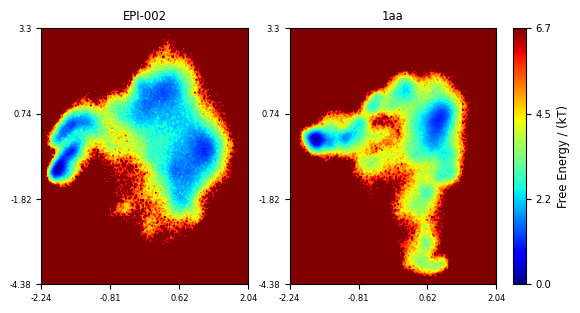

In [408]:
subplots_fes2d([i[:, :2] for i in projs], 1, 2, labels[1:], figsize=(6, 4), bins=180)

In [181]:
def iter_longest_timescale(dtraj, lagtimes = np.arange(5, 550, 50), bayes=False, reversible:bool=False):
    return np.array([longest_timescale(dtraj, lag, bayes=bayes, reversible=reversible) for lag in lagtimes])


import deeptime
def longest_timescale(dtraj: np.ndarray,
                      lagtime: int,
                      bayes:bool=False,
                      reversible:bool=False,
                      confidence: float=0.66,
                      n_samples: int=250):
    # deal with failing models during parameter scans
    if bayes:
        try:
            stats = deeptime.markov.msm.BayesianMSM(lagtime=lagtime,
                                                    reversible=reversible,
                                                    n_samples=n_samples).fit_fetch(dtraj).gather_stats('timescales',
                                                                                                 confidence=confidence)
            return stats.mean[0], stats.L[0], stats.R[0]
        except:
            return np.nan
    else:   
        try:
            return deeptime.markov.msm.MaximumLikelihoodMSM(reversible=reversible
                                                           ).fit_fetch(dtraj,lagtime=lagtime).timescales(1).item()
        except:
            return np.nan




In [518]:
n_clusters = np.array([8, 10, 12, 15, 18, 20])
clusters = {'epi':{}, '1aa': {}}
for n in n_clusters:
    clusters['epi'][n], clusters['1aa'][n] = (Kmeans(projs[i], n, 3, max_iter=1200, n_init=25)[0]
                                              for i in range(2))

In [508]:
n_clusters = np.array([1000, 1500, 2000, 2500, 3000])

for n in n_clusters:
     clusters['1aa'][n] = [Kmeans(projs[i], n, 2, max_iter=1200, n_init=25)[0] for i in range(1,2)][0]


KeyboardInterrupt



In [183]:
from writhe_tools.plots import lineplot1D
steps = np.arange(5, 2000, 100)
dt = 0.2 #ns
times = {'epi':{'lags': steps},
         '1aa': {'lags': steps}}

for n in n_clusters:
    times['epi'][n], times['1aa'][n] = (iter_longest_timescale(clusters[key][n], lagtimes=steps)
                                        for key in clusters.keys())

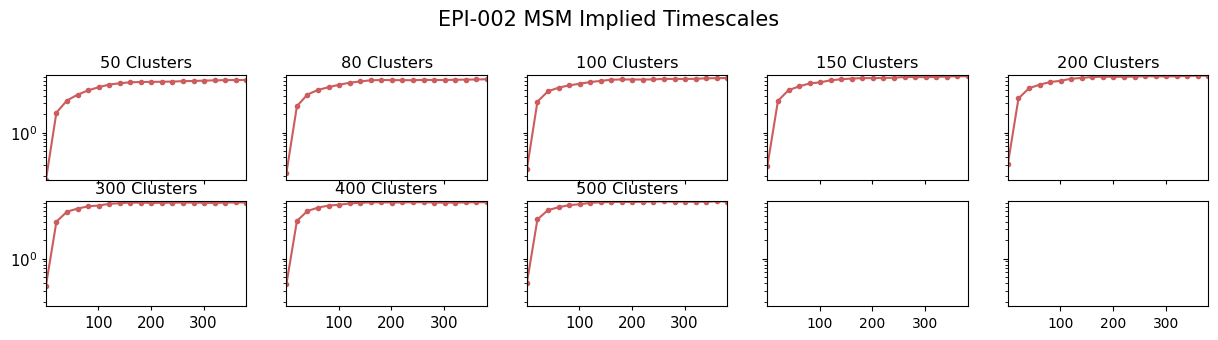

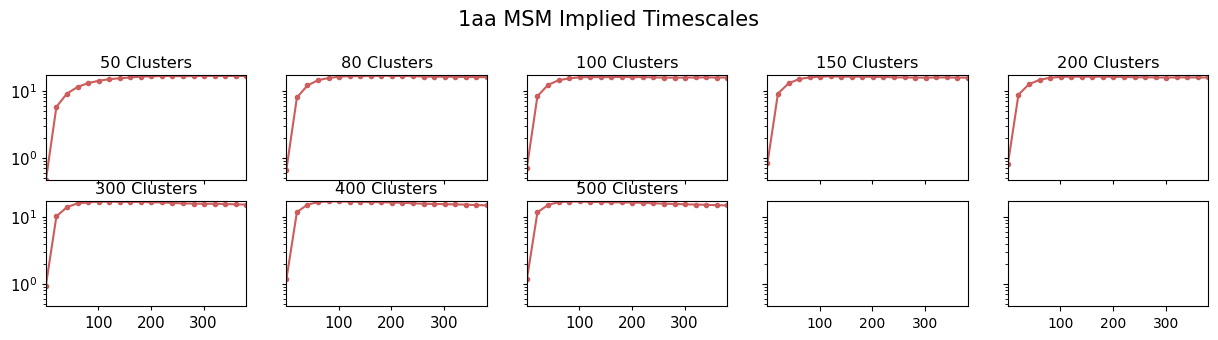

In [184]:
for key, label in zip(times.keys(), labels[1:]):
    fig, axes = plt.subplots(2, 5, figsize=(15, 3), sharey=True, sharex=True)
    fig.suptitle(f"{label} MSM Implied Timescales", y = 1.1, size=15)
    for n, ax in zip(n_clusters, axes.flat):
        lineplot1D(times[key][n] * 1e-3 * dt,
                   steps * dt,
                   # timescale[0].T[1]  * 1e-3 * dt,
                   # timescale[0].T[2]  * 1e-3 * dt,
                   # fill_color=c1,
                   # fill_alpha=0.1,
                   # label=d if k == 10 else None,
                   marker='o',
                   ms = 3,
                   ax=ax,
                   font_scale=.9,
                   title=f"{n} Clusters",
                   #ymax=ymax,
                   color="indianred",
                   yscale="log",
                   ylabel=f"{symbols('mu')}s" if n == 10 else None,
                          )
    #fig.tight_layout()
        
        

In [225]:
clusters = load_dict('/data/r1r2/lba_clusters_dim_2.pkl')

In [365]:
clusters['1aa'].keys()

dict_keys([10, 12, 15, 20, 25, 50, 100, 150, 200])

In [ ]:
from deeptime.markov import

In [541]:
msms = [MarkovModel(i[n_cluster]).estimate_msm(tau, 5).estimate_hmm(n)
        for i, n, tau, n_cluster in zip(clusters.values(), (4, 4), (850, 1000), (8, 8))]

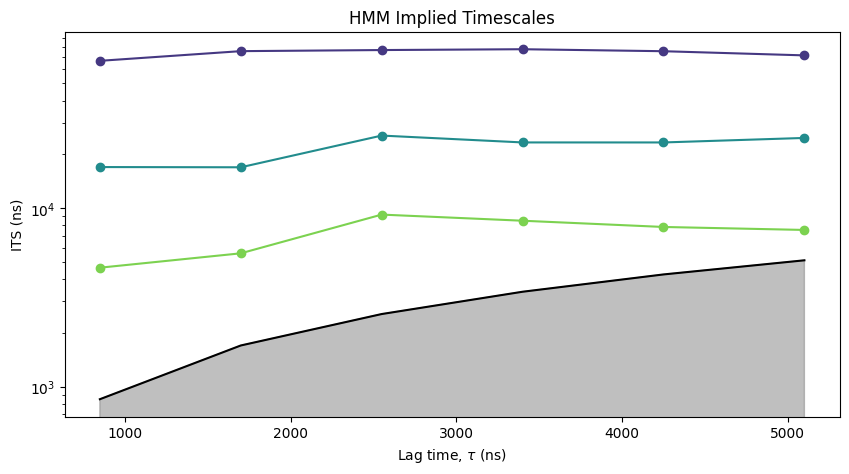

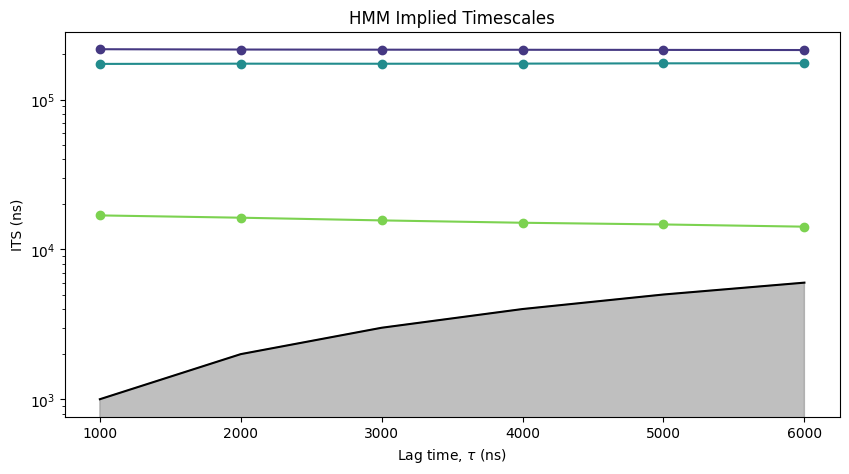

In [538]:
for i in msms:
    i.its('hmm')

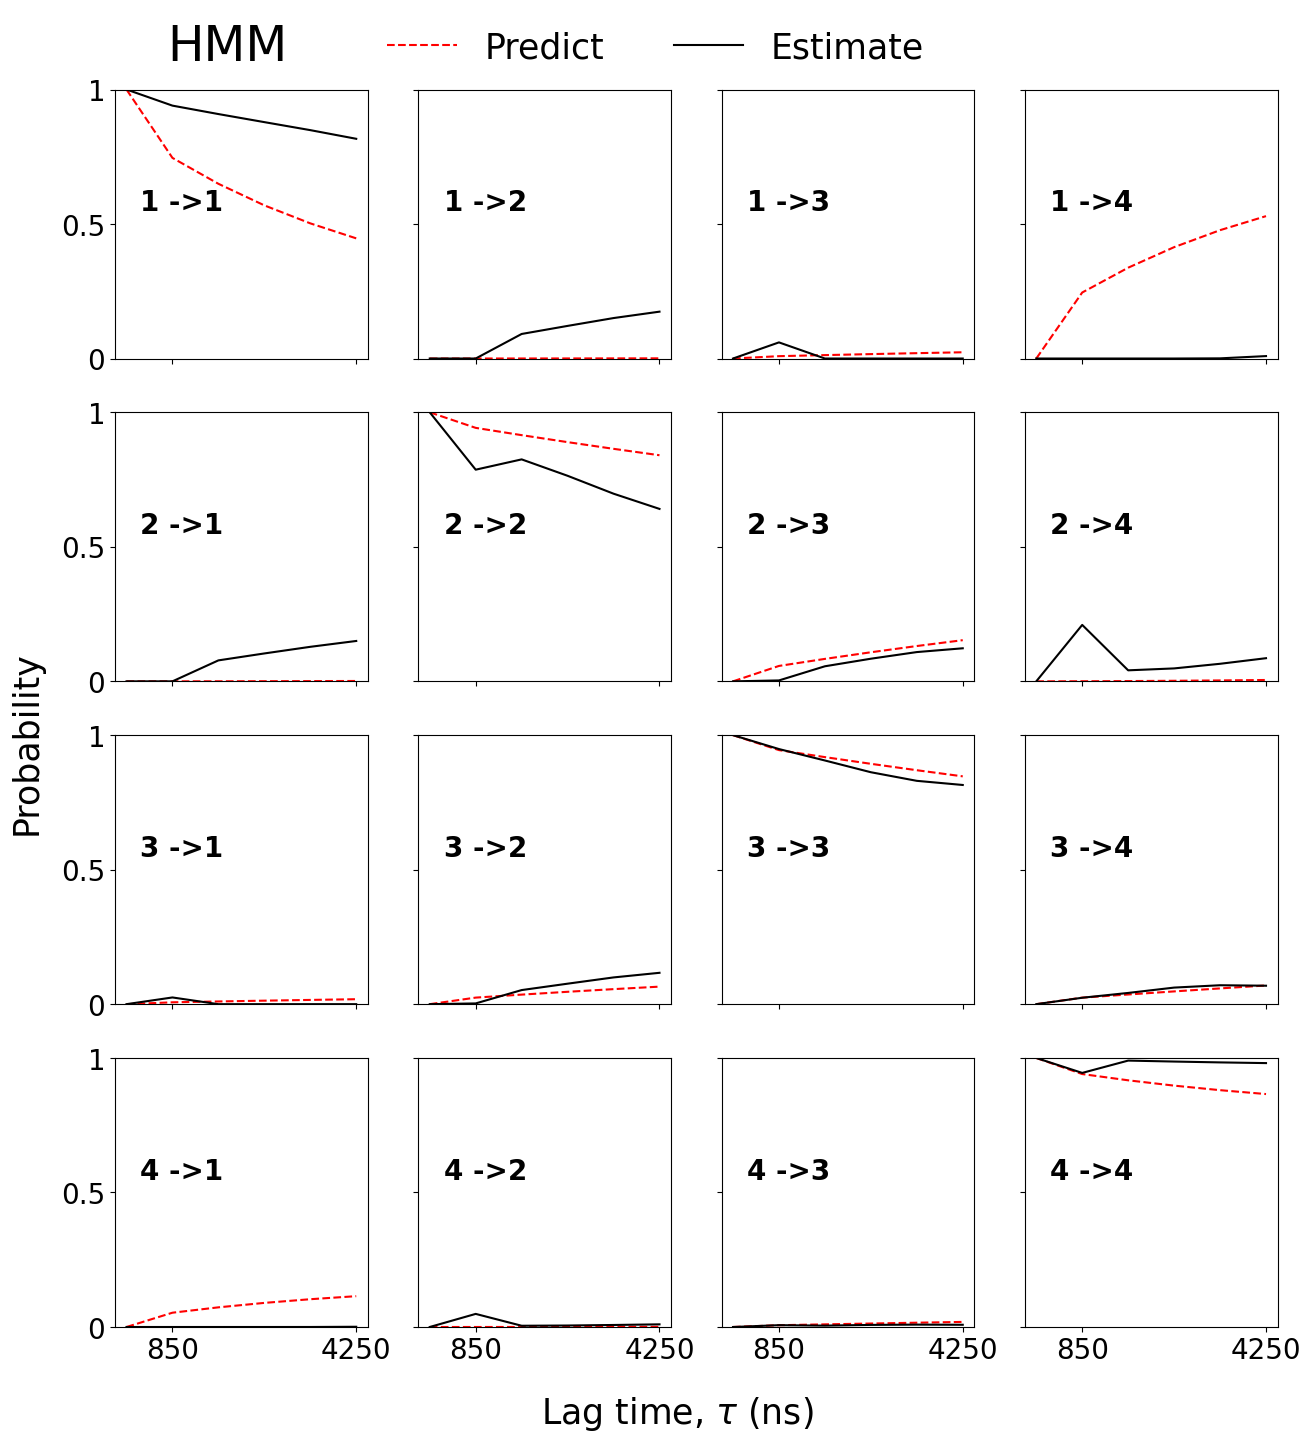

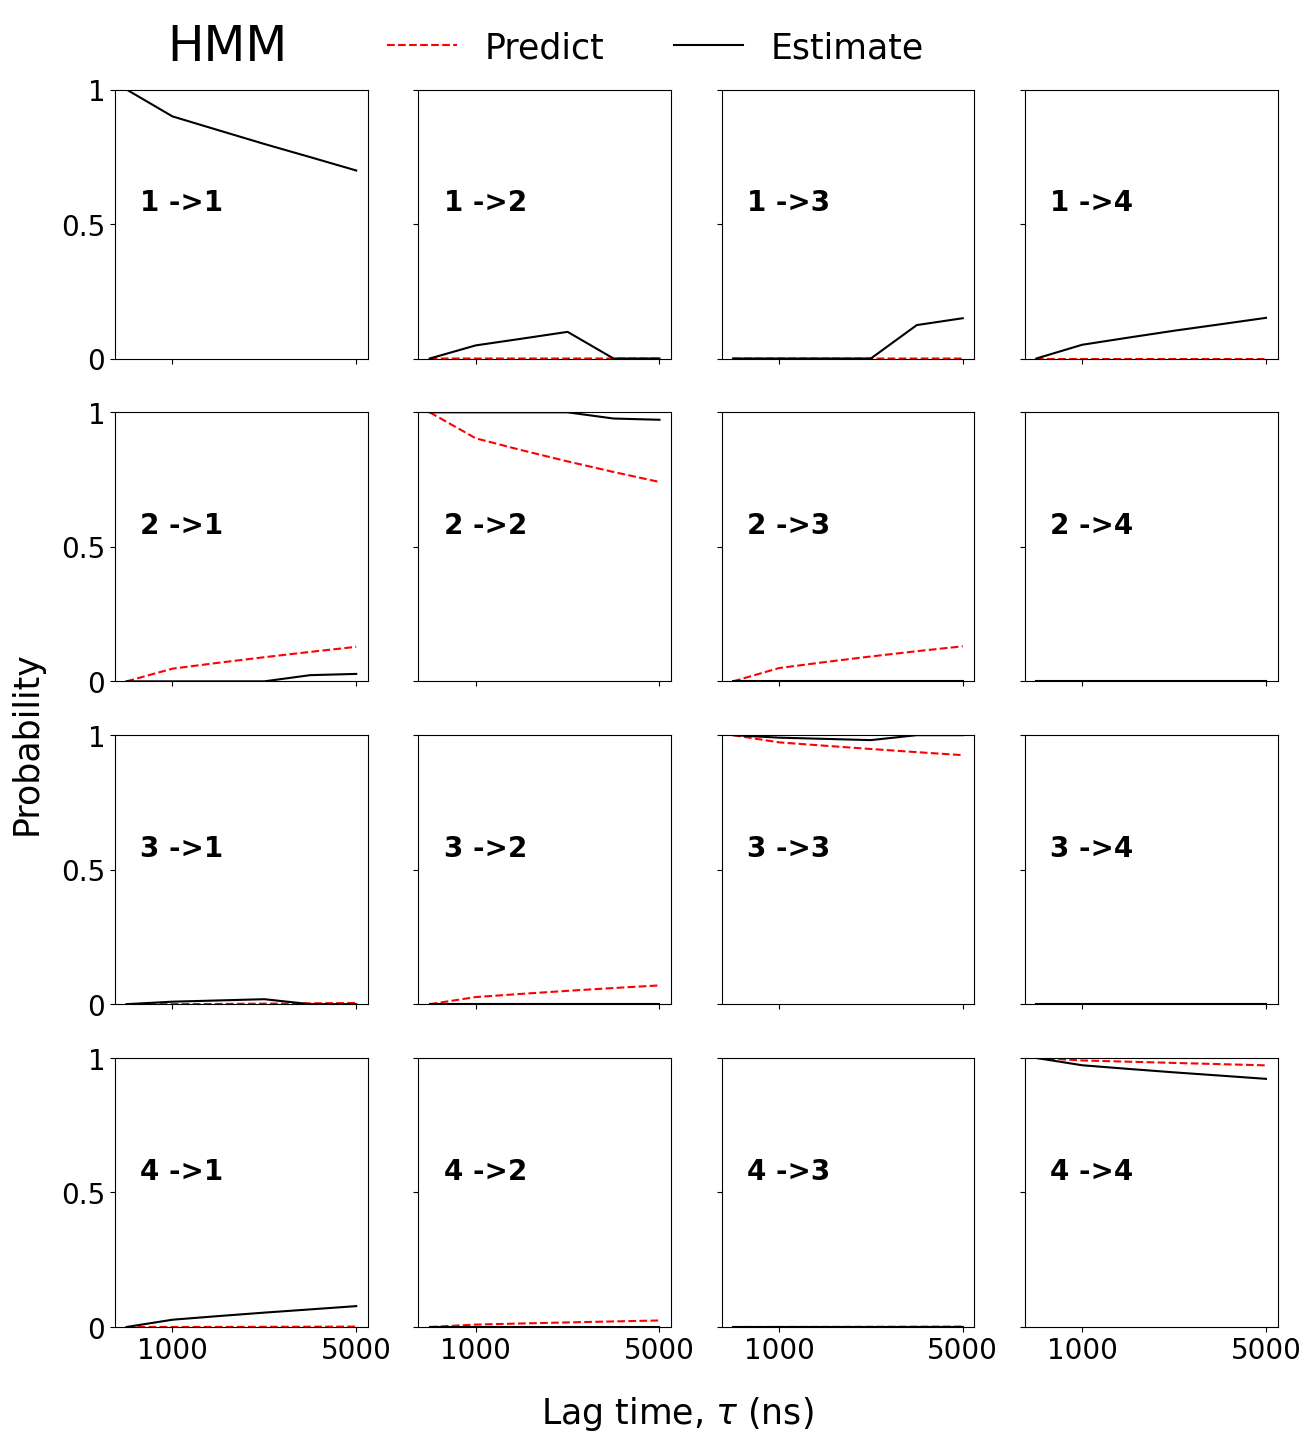

In [540]:
for i in msms:
    i.cktest('hmm')

In [444]:
#msms[-1] = MarkovModel(clusters['1aa'][12]).estimate_msm(700, 5).estimate_hmm(4)

In [515]:
msms = [MarkovModel(i[n_cluster]).estimate_msm(tau, 15)
        for i, n, tau, n_cluster in zip(clusters.values(), (4, 4), (150, 150), (2000, 2000))]

Skipping state set [1736] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [1736] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [1736] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [1736] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [1736] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [1736] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [1736] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..


ValueError: all input arrays must have the same shape

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

for model, ax in zip(msms, axes.flat):
    model.its('msm', ax=ax, n_its=6, )

plt.plot(ck.predictions[:, 0, 0])
plt.plot(msms[0].hmm['data']['ck_pred'][:, 0, 0])

In [482]:
from writhe_tools.msm_tools import plot_cktest

In [501]:
prediction_errors = np.stack([np.stack(i).std(0) for i in ck.predictions_samples])
prediction_errors[0] = np.eye(4)

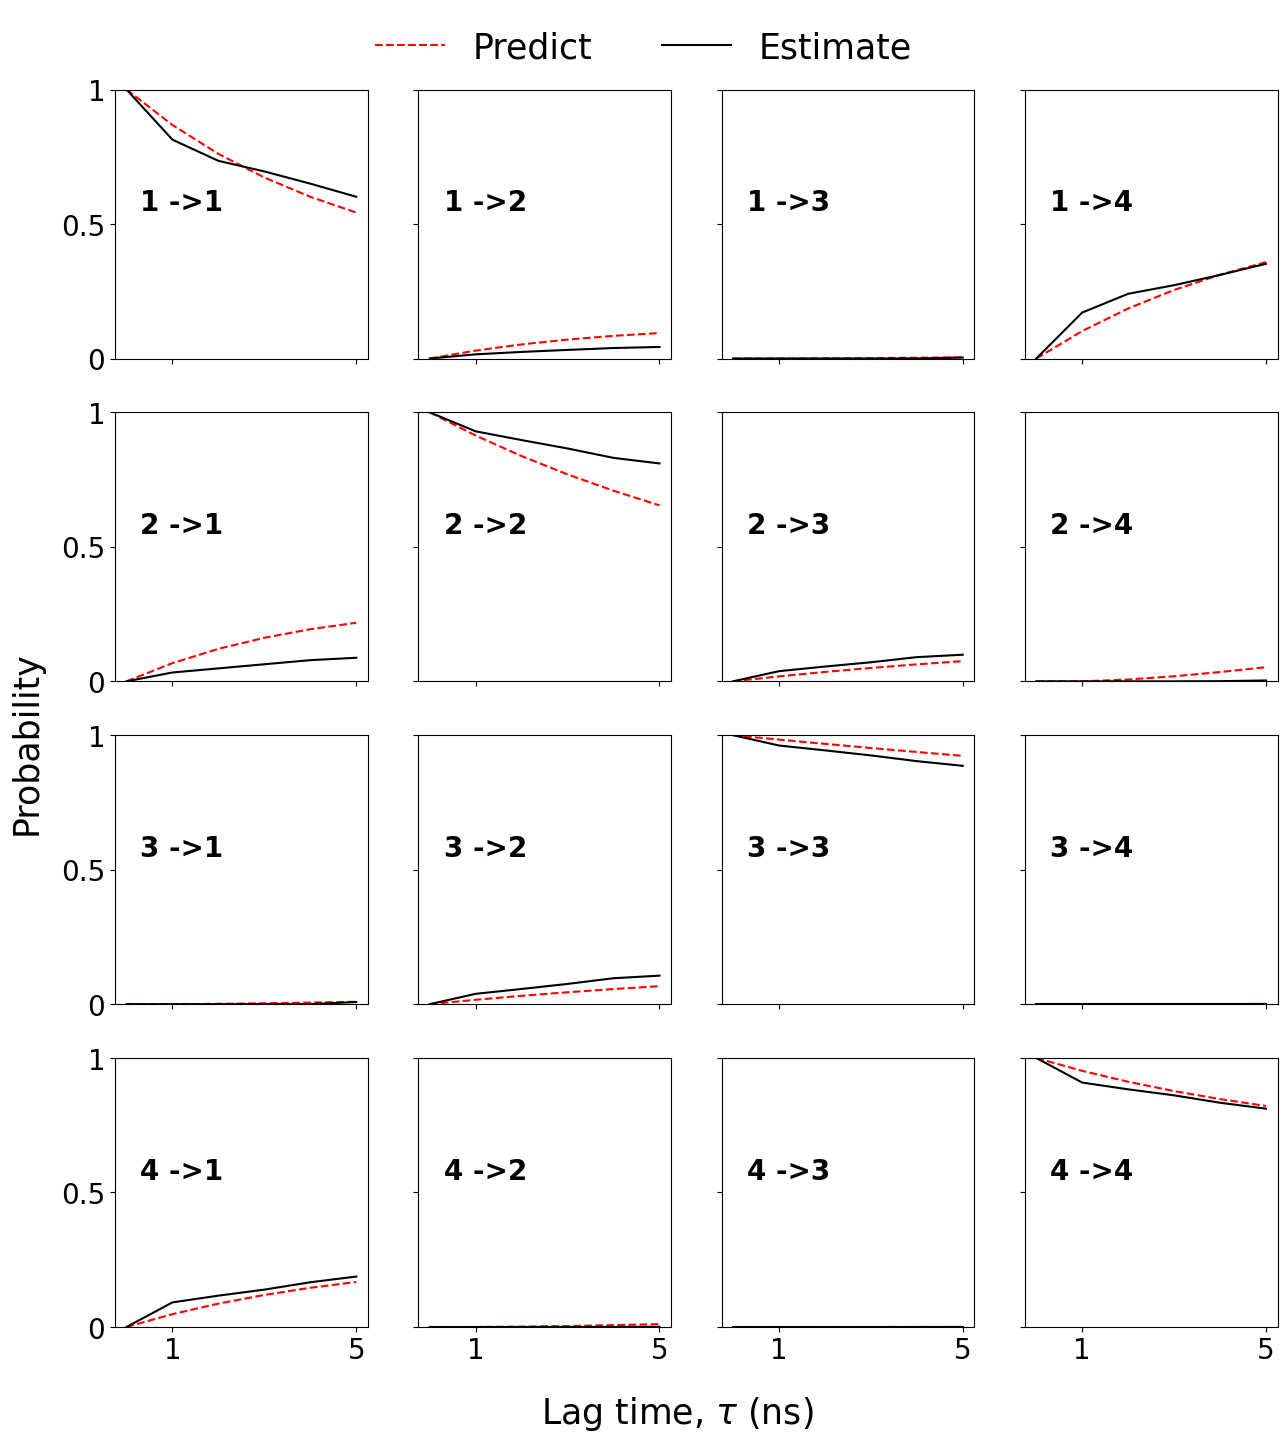

In [503]:
plot_cktest(ck.predictions,
            msms[0].hmm['data']['ck_est'],)
           
        

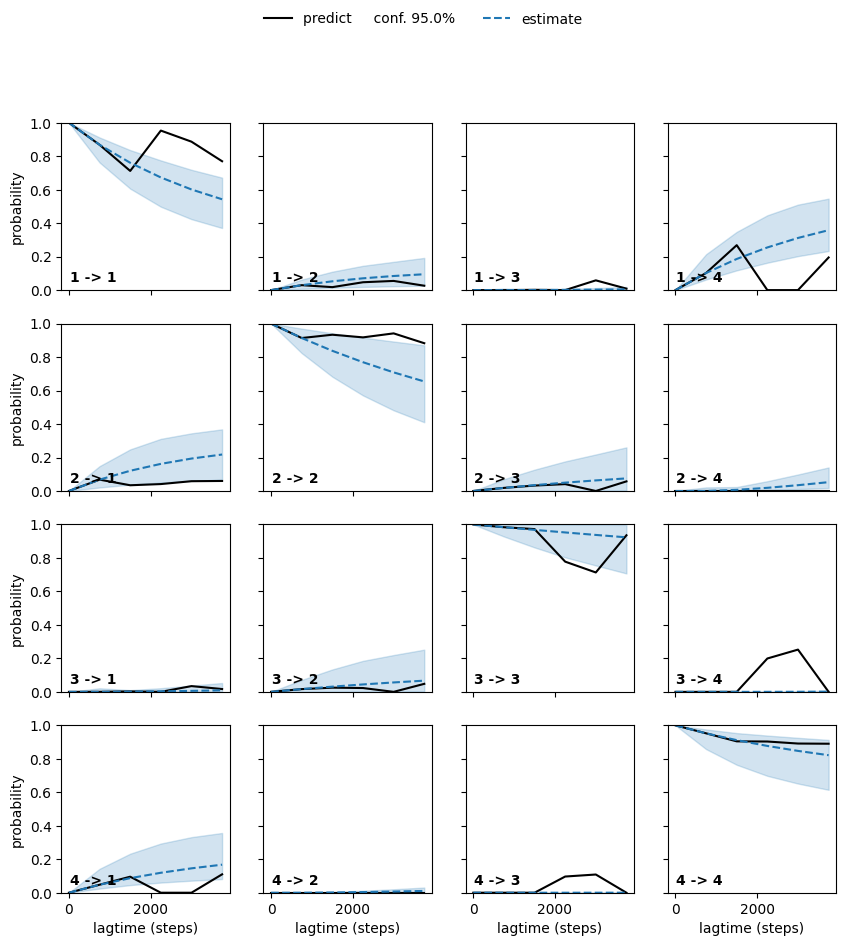

In [480]:
from deeptime.markov import hmm

# Estimate Bayesian HMM from a discrete trajectory
# observation_trajectory: list of integer-valued sequences (e.g., [np.array([0, 1, 2, 0, ...])])
# n_hidden: number of hidden states
# lag: lag time

def estimate_bayesian_hmm(observation_trajectory, n_hidden=2, lag=1, n_samples=100):
    estimator = hmm.BayesianHMM.default(
        observation_trajectory,
        n_hidden_states=n_hidden,
        lagtime=lag,
        n_samples=n_samples
    )
    return estimator.fit(observation_trajectory).fetch_model()

bayes = [estimate_bayesian_hmm(clusters['epi'][10], 4, 750 * i, 500) for i in (1, 2, 3, 4, 5)]
ck = bayes[0].ck_test(bayes, err_est=False)
ck.estimates_ = msms[0].hmm['data']['ck_est']
ck.plot()

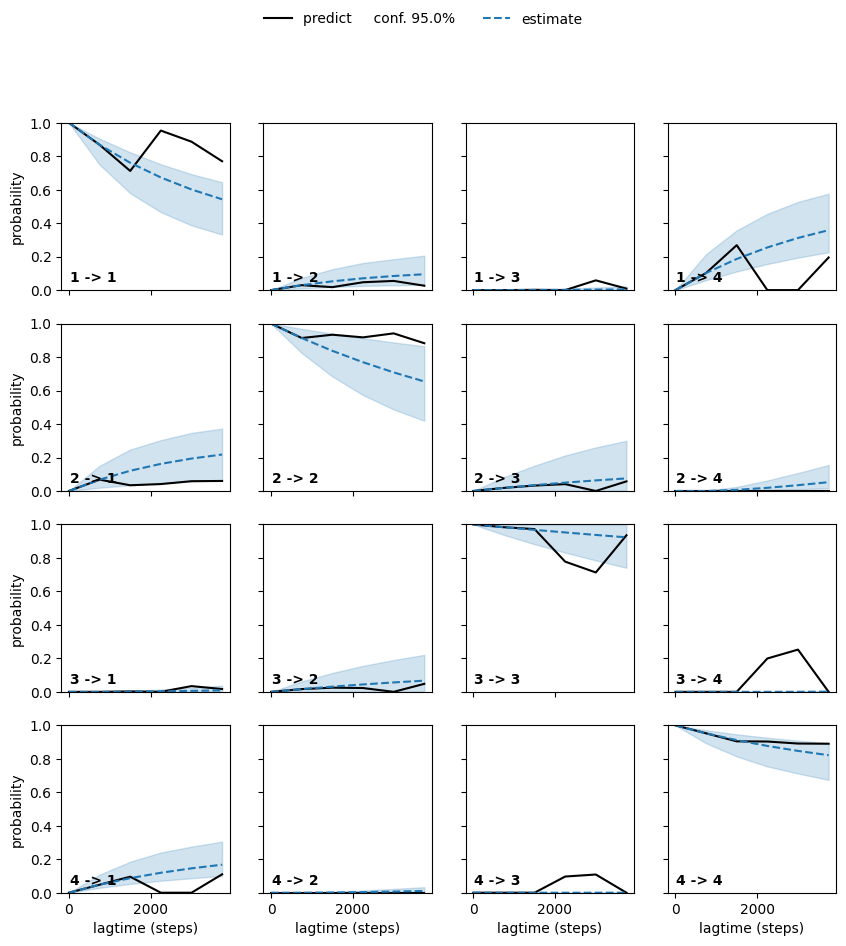

In [467]:
ck = bayes[0].ck_test(bayes)
ck.plot()

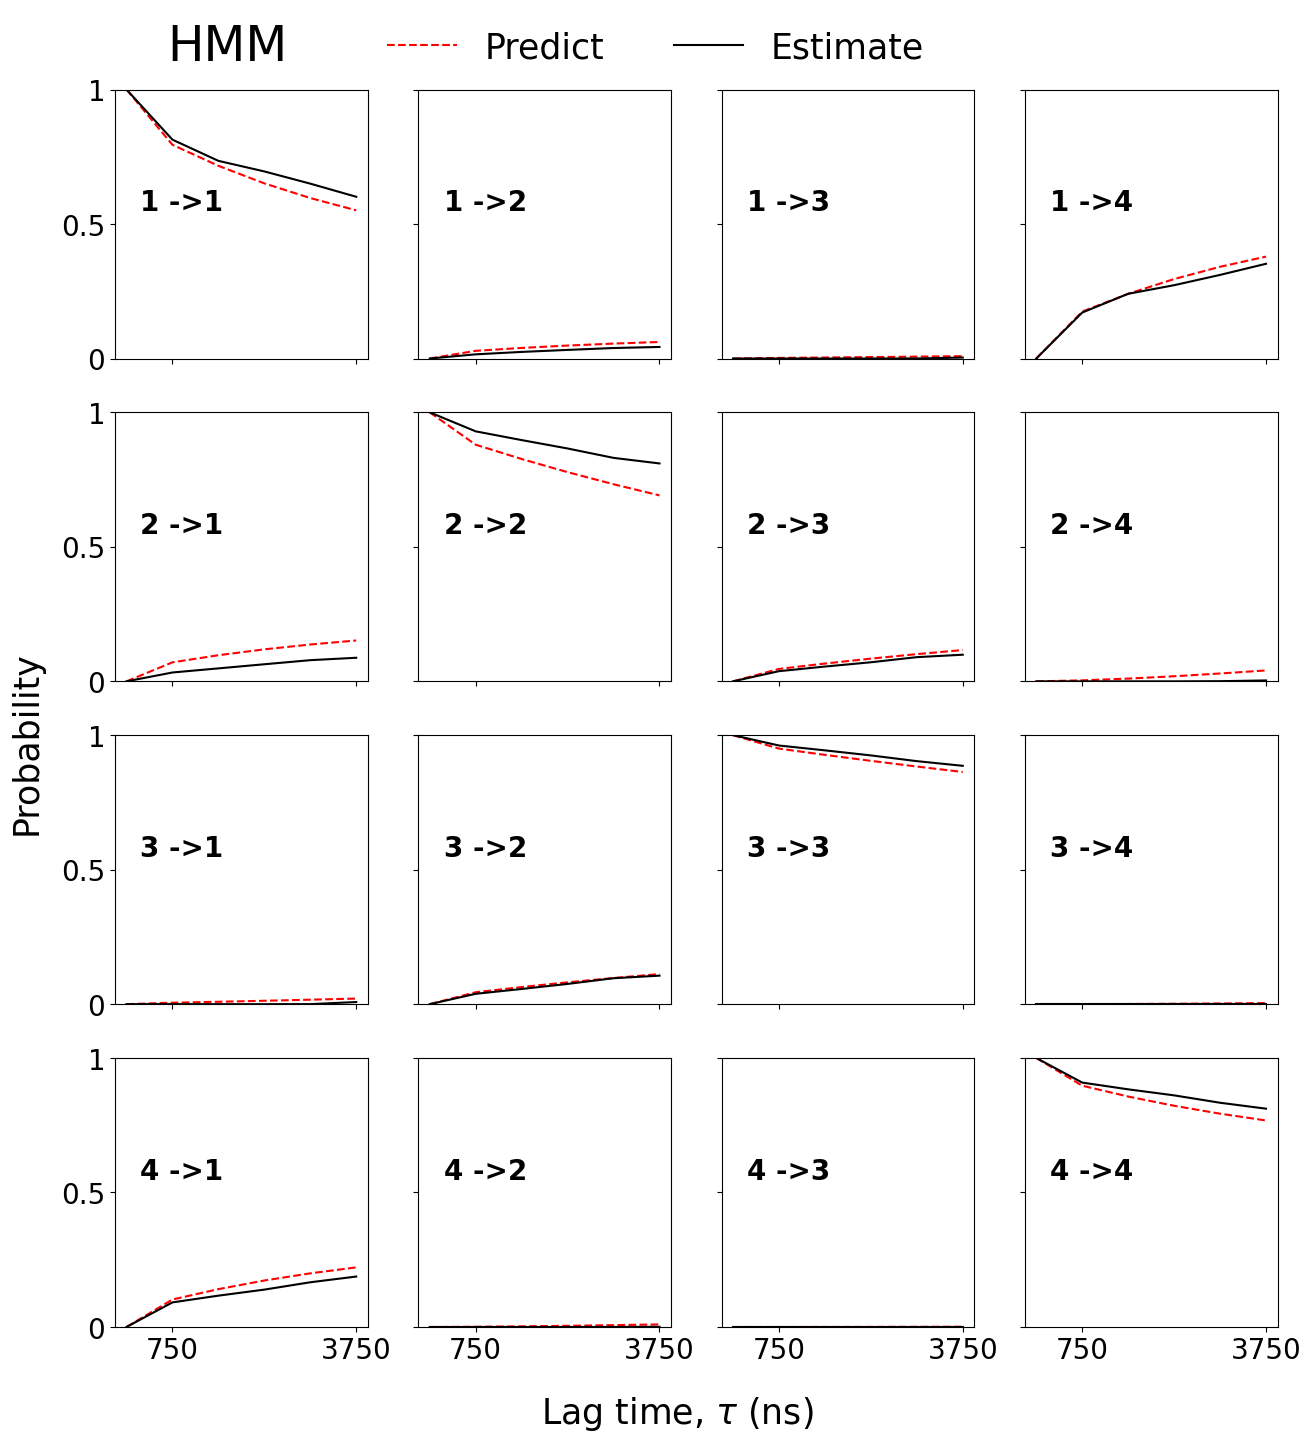

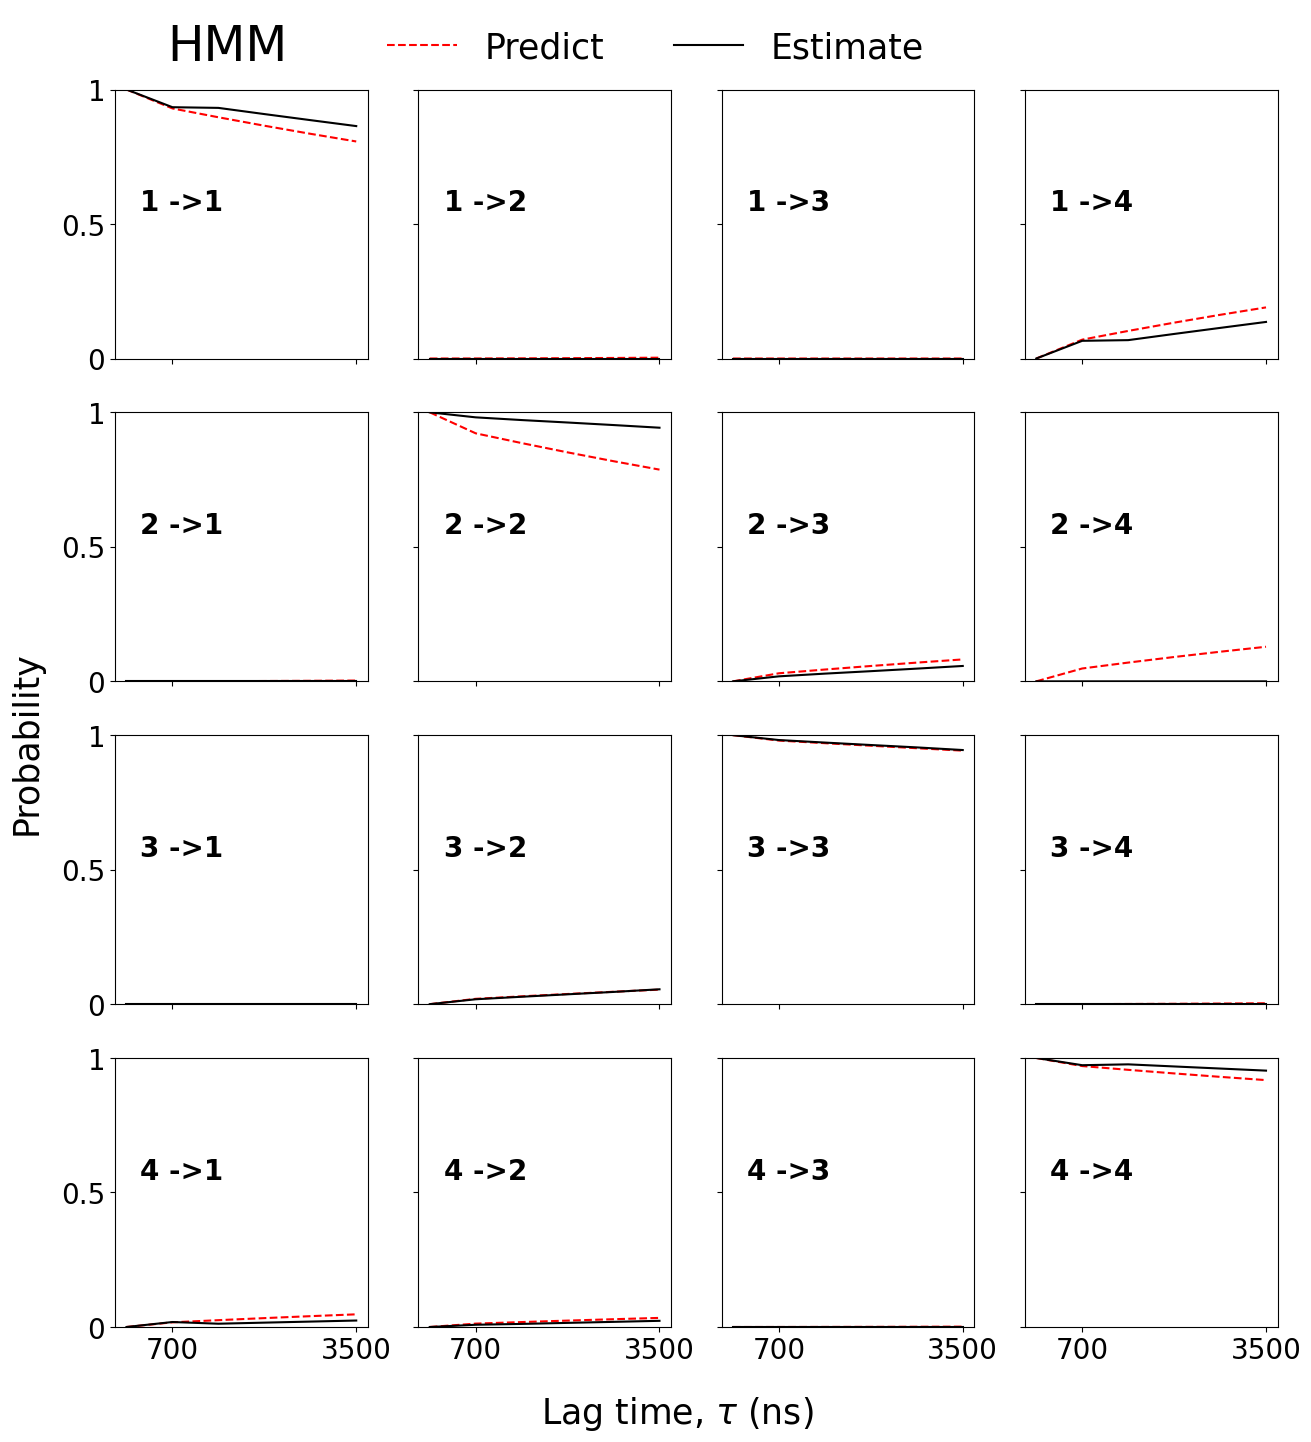

In [468]:
for i in msms:
    i.cktest('hmm')

In [ ]:
bayes = [deeptime.markov.hmm.BayesianHMM(model.) for model in msms]